**References:**

---
The below code has been refered from multiple Kaggle HomeDepot competition solutions and from blogs. Below is the  list of the same.

1. Main Reference - Kaggle Solution -->  https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222
2. https://github.com/bhattbhavesh91/GA_Sessions/blob/master/ga_dsmp_5jan2019/16_feature_selection.ipynb
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
4. https://gilberttanner.com/blog/introduction-to-ensemble-learning
5. http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/
6. Main reference for approach 1 : https://github.com/kriz17/Home-Depot-Product-Search-Relevance

# Data Loading and imports

**Imports and dependencies**

In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import sklearn as sk
import regex as re
import nltk
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from nltk import ngrams
from nltk.metrics.distance import edit_distance
from nltk.metrics.distance import jaccard_distance
import pickle

In [ ]:
#https://stackoverflow.com/questions/48340341/how-to-read-csv-to-dataframe-in-google-colab
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
train_data_path = '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/train.csv'
prod_desc_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/product_descriptions.csv'
attr_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/attributes.csv'
test_data_path= '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/test.csv'

In [ ]:
df_train=pd.read_csv(train_data_path,encoding = "ISO-8859-1")
df_pd_desc=pd.read_csv(prod_desc_path)
df_attributes=pd.read_csv(attr_path)
df_test=pd.read_csv(test_data_path,encoding = "ISO-8859-1")

In [ ]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [ ]:
df_pd_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
df_attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


# Exploratory Data Analysis - EDA

In [ ]:
print('Train set:  ')
print(df_train.isna().sum())
print(df_train.describe())
print('------------------------------------------------------------------')
print('Test set')
print(df_test.isna().sum())
print(df_test.describe())

Train set:  
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64
                  id    product_uid     relevance
count   74067.000000   74067.000000  74067.000000
mean   112385.709223  142331.911553      2.381634
std     64016.573650   30770.774864      0.533984
min         2.000000  100001.000000      1.000000
25%     57163.500000  115128.500000      2.000000
50%    113228.000000  137334.000000      2.330000
75%    168275.500000  166883.500000      3.000000
max    221473.000000  206650.000000      3.000000
------------------------------------------------------------------
Test set
id               0
product_uid      0
product_title    0
search_term      0
dtype: int64
                  id    product_uid
count  166693.000000  166693.000000
mean   123932.839741  149713.170445
std     71518.389174   37270.476881
min         1.000000  100001.000000
25%     61669.000000  116665.000000
50%    124004.000000  142445.000000
75%    18703

**Inference**:



---



Train data:
contains 74066 records,

1.   contains 74066 records,
2.   no empty records
3.   relevance has a mean value of 2.381634
3.   sample standard deviation of 0.533984 (with large sample size of 74066)
4.   this standard deviation is quite close to the population standard deviation

In [ ]:
print("# of unique search_terms (TRAIN) : ", len(df_train.search_term.unique()))
print("# of unique search_terms (TEST) : ", len(df_test.search_term.unique()))
print('------------------------------------------------------------------')
print("# of unique products (TRAIN) : ", len(df_train.product_uid.unique()))
print("# of unique products (TEST) : ", len(df_test.product_uid.unique()))
print('------------------------------------------------------------------')
print('# of rows with duplicate search_term and product_uid (TRAIN): ',df_train[['search_term', 'product_uid']].duplicated().sum())
print('# of rows with duplicate search_term and product_uid (TEST): ',df_test[['search_term', 'product_uid']].duplicated().sum())

# of unique search_terms (TRAIN) :  11795
# of unique search_terms (TEST) :  22427
------------------------------------------------------------------
# of unique products (TRAIN) :  54667
# of unique products (TEST) :  97460
------------------------------------------------------------------
# of rows with duplicate search_term and product_uid (TRAIN):  0
# of rows with duplicate search_term and product_uid (TEST):  13


In [ ]:
print(df_pd_desc.isna().sum())
print('------------------------------------------------------------------')
print("Total # of products :", len(df_pd_desc))
print("Total # of duplicate products :", df_pd_desc['product_uid'].duplicated().sum())

product_uid            0
product_description    0
dtype: int64
------------------------------------------------------------------
Total # of products : 124428
Total # of duplicate products : 0


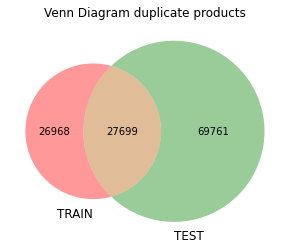

------------------------------------------------------------------


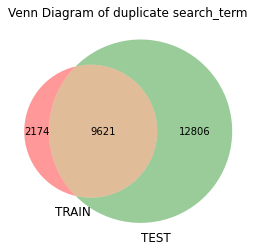

------------------------------------------------------------------


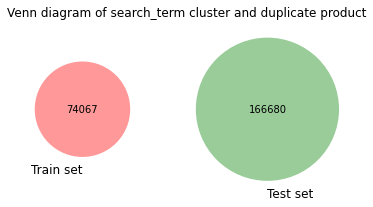

In [ ]:
#Duplicate products comparing Train and Test dataset
set1 = set(df_train.product_uid.to_list())
set2 = set(df_test.product_uid.to_list())
venn2([set1, set2], ('TRAIN', 'TEST'))
plt.title("Venn Diagram duplicate products")
plt.show()
print('------------------------------------------------------------------')
#Duplicate search_term comparing Train and Test dataset
set1 = set(df_train.search_term.to_list())
set2 = set(df_test.search_term.to_list())
venn2([set1, set2], ('TRAIN', 'TEST'))
plt.title("Venn Diagram of duplicate search_term")
plt.show()
print('------------------------------------------------------------------')
#Overlap between search_term and duplicate product cluster
set1 = set(df_train['search_term'].astype(str) + ' ' + df_train['product_uid'].astype(str))
set2 = set(df_test['search_term'].astype(str) + ' ' + df_test['product_uid'].astype(str))
venn2([set1, set2], ('Train set', 'Test set'))
plt.title("Venn diagram of search_term cluster and duplicate product")
plt.show()

**Inference:**


---





1.   There are 27699 duplicate products between train set and test set.
2.   Around 80% of the search_term are in train dataset are present in test dataset
3.   There are no overlaps between search_term and product clusters in both train and test dataset




Text(0.5, 0.98, 'Distribution of relevance scores')

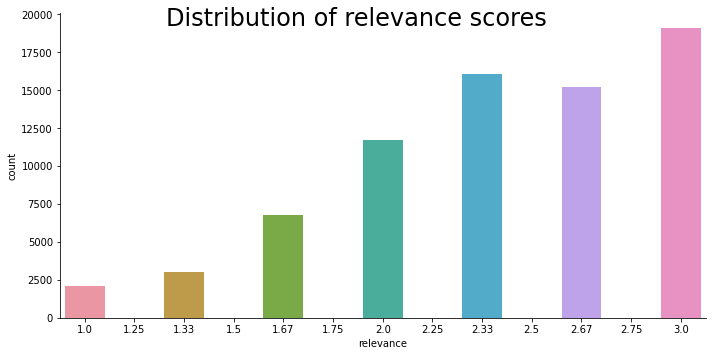

In [ ]:
plot=sns.catplot(x='relevance',kind='count',data=df_train,height=5,aspect=2)
#https://stackoverflow.com/questions/64258570/seaborn-title-error-attributeerror-facetgrid-object-has-no-attribute-set-t
plot.fig.suptitle("Distribution of relevance scores",
                  fontsize=24, fontdict={"weight": "bold"})


**Inference:**


---


TRAIN dataset has a distribution skewed towards high relevance i.e. from 2.33 to 3 compared to the relatively few lower score values from 1.0 to 2.0

100%|██████████| 166693/166693 [00:04<00:00, 33929.79it/s]


Text(0.5, 1.0, 'TEST Dataset')

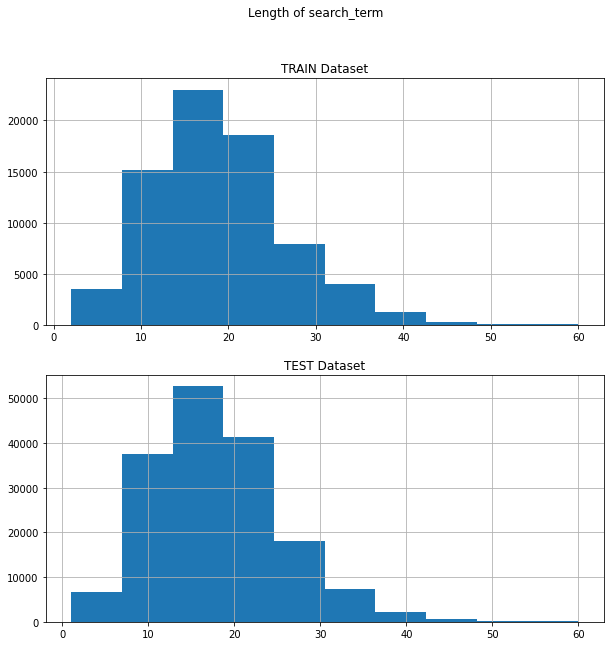

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Length of search_term')
search_term_len_tain = df_train.progress_apply(lambda x: len(x['search_term']), axis=1)
search_term_len_tain.hist(ax=axs[0])
search_term_len_test = df_test.progress_apply(lambda x: len(x['search_term']), axis=1)
search_term_len_test.hist(ax=axs[1])
axs[0].set_title('TRAIN Dataset')
axs[1].set_title('TEST Dataset')

**Inference:**


---


1.   search_term length is similar in both TRAIN and TEST dataset
2.   it is close to normal distribution with a mean of ~16


Text(0.5, 1.0, 'TEST Dataset')

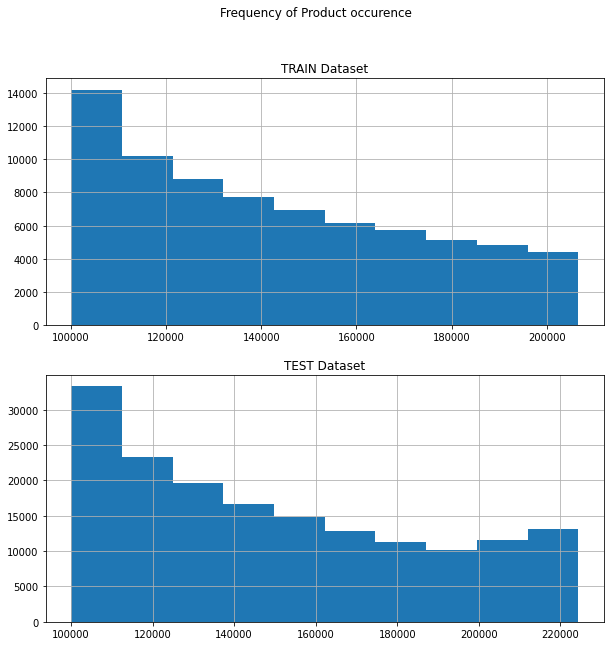

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Frequency of Product occurence')
df_train['product_uid'].hist(ax=axs[0])
df_test['product_uid'].hist(ax=axs[1])
axs[0].set_title('TRAIN Dataset')
axs[1].set_title('TEST Dataset')

**Inference:**


---


1.   frequency of occurrence of products is similar in both TRAIN and TEST dataset

In [ ]:
df_attributes.isna().sum()

product_uid     155
name            155
value          2284
dtype: int64

**Inference:**


---
1.  There are 155 rows with a null values in product_uid and name column and 2284 rows with a null value column in the product attribute. 
2.  It is obvious that some products don't have attributes
3.  Nevertheless if the attributes are not valid they should not be included in this table and left empty.

In [ ]:
# List of attributes having product_uid but no value
df_attributes[np.invert(df_attributes.isnull().product_uid) & df_attributes.isnull().value]

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
7898,100329.0,Fastener recommendation,NaN
...,...,...,...
2040533,224234.0,Hardware Finish Family,NaN
2040775,224246.0,Mosaic Sub Unit Length (in.),NaN
2040776,224246.0,Mosaic Sub Unit Width (in.),NaN
2041817,224289.0,Bore offset,NaN


In [ ]:
# List with out producrt_uid will have remaining fields empty
df_attributes[df_attributes.isnull().product_uid].isnull().sum()

product_uid    155
name           155
value          155
dtype: int64

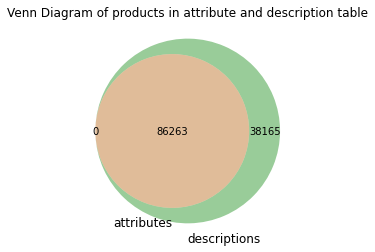

In [ ]:
set1 = set(df_attributes.product_uid.dropna().astype('int64'))
set2 = set(df_pd_desc.product_uid)
venn2([set1, set2], ('attributes', 'descriptions'))
plt.title("Venn Diagram of products in attribute and description table")
plt.show() 

**Inference:**


---
1.  Description contains all the products & its attributes in both the train and test dataset

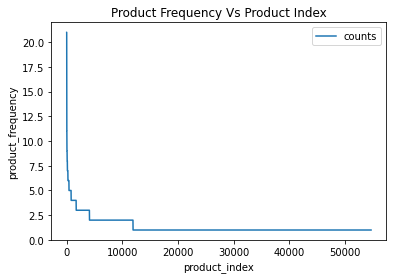

In [ ]:
#Product Frequency
#reference --> https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
product_count_frequency = df_train['product_uid'].value_counts().rename_axis('unique_values').reset_index(name='counts')

#reference --> https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.line.html
product_count_frequency.plot.line(y='counts',title='Product Frequency Vs Product Index',xlabel='product_index',ylabel='product_frequency')

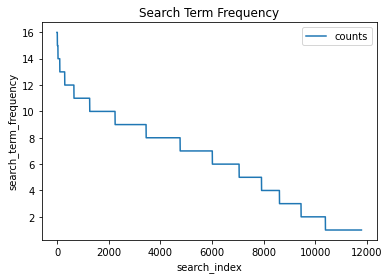

In [ ]:
#search_term frequency
search_question_frequency = df_train['search_term'].value_counts().rename_axis('unique_values').reset_index(name='counts')
search_question_frequency.plot.line(y='counts',title='Search Term Frequency',xlabel='search_index',ylabel='search_term_frequency')

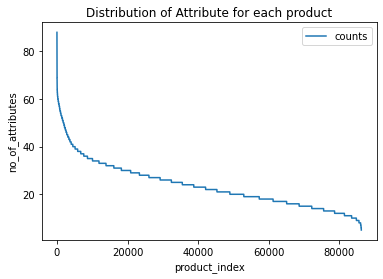

In [ ]:
#attribute frequency
attribute_frequency = df_attributes['product_uid'].value_counts().rename_axis('unique_values').reset_index(name='counts')
attribute_frequency.plot.line(y='counts',title='Distribution of Attribute for each product',xlabel='product_index',ylabel='no_of_attributes')

**Inference:**


---
1.  small number of attributes have a large number of products available
2.  remaining attributes have very few products with them.
3.  products with attributes will have a brand name

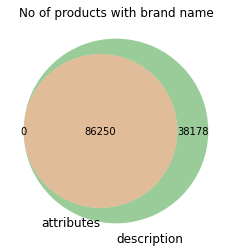

In [ ]:
set1 = set(df_attributes[df_attributes['name'] == 'MFG Brand Name'].product_uid.astype('int64'))
set2 = set(df_pd_desc.product_uid)
venn2([set1, set2], ('attributes', 'description'))
plt.title("No of products with brand name")
plt.show() 

**Inference:**


---
1. only 13 products that do not have a Brand Name
2. use of brand name is important, because relevance score is calculated based on matches with brand name


# Data Pre-Processing


**Drop null values**

In [ ]:
train_data_path = '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/train.csv'
prod_desc_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/product_descriptions.csv'
attr_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/attributes.csv'
test_data_path= '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/test.csv'

df_train=pd.read_csv(train_data_path,encoding = "ISO-8859-1")
df_pd_desc=pd.read_csv(prod_desc_path)
df_attributes=pd.read_csv(attr_path)
df_test=pd.read_csv(test_data_path,encoding = "ISO-8859-1")

In [ ]:
print(df_train.shape)

(74067, 5)


In [ ]:
valid = [3.00, 2.33, 2.67, 2.00, 1.67, 1.33, 1.00]
df_train['relevance_class'] = df_train['relevance'].apply(lambda score: str(min(valid, key=lambda x:abs(x-score))))
print(df_train['relevance_class'].unique())

['3.0' '2.33' '2.67' '2.0' '1.0' '1.67' '1.33']


# Approach 1: Split Train dataset into train and test data
**Note:** test.csv will not be considered

**Important Note**

---


**SPLITTING INTO TRAIN AND TEST**

Need to split the data with equal dist of relevance scores. Therefore, first relevance scores are converted into calsses and then splitting them into train and test.




In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_train, stratify=df_train['relevance_class'], train_size=0.8, shuffle=True, random_state=122)
print(df_train.shape)
print(df_test.shape)

(59253, 6)
(14814, 6)


In [ ]:
#dropping id column of train df
df_train = df_train.drop(['id'], axis=1)

# dropping null values from attribute df
df_attributes = df_attributes.dropna()

#attribute table: product_uid is in float64 and hece converting to int64 to be in sync with other df
df_attributes = df_attributes.astype({'product_uid': 'int64'})

# retrieve data on brands
brand_name_temp = df_attributes[df_attributes['name'] == 'MFG Brand Name']
brand_name_temp['brand'] = brand_name_temp['value']
brand_name_temp = brand_name_temp.drop(['name', 'value'], axis=1)
brand_name_temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,product_uid,brand
9,100001,Simpson Strong-Tie
37,100002,BEHR Premium Textured DeckOver
69,100003,STERLING
93,100004,Grape Solar
122,100005,Delta
...,...,...
2044702,224422,Everbilt
2044734,224423,Coastal Shower Doors
2044747,224424,stufurhome
2044774,224425,Home Decorators Collection


**Merging attribute columns to attribute create summary**

In [ ]:
%%time
df_attributes['attribute_summary'] = df_attributes.progress_apply(lambda x: (x['name'] + ' ' + x['value']) ,axis=1)
df_attributes = df_attributes.drop(labels=['name', 'value'], axis=1)
df_attributes = pd.pivot_table(df_attributes, index='product_uid', aggfunc= lambda x : " ".join(x))

100%|██████████| 2042519/2042519 [00:37<00:00, 53969.86it/s]


CPU times: user 38 s, sys: 771 ms, total: 38.8 s
Wall time: 40.3 s


In [ ]:
print(df_attributes.head())

                                             attribute_summary
product_uid                                                   
100001       Bullet01 Versatile connector for various 90° c...
100002       Application Method Brush,Roller,Spray Assemble...
100003       Built-in flange Yes Bullet01 Slightly narrower...
100004       Amperage (amps) 8.56 Bullet01 Positive power t...
100005       Bath Faucet Type Combo Tub and Shower Built-in...


**Inference**

---
1.  resultant dataframe contains product_uid with the corresponding merged attribute_summary


**Merge product description with train and test data frame**

In [ ]:
df_train = df_train.merge(df_pd_desc, on='product_uid', how='left')
df_test = df_test.merge(df_pd_desc, on='product_uid', how='left')


In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,relevance_class,product_description
0,173778,Winters Instruments P9U 90 Series 2 in. Panel ...,tekton pressure gauge,2.33,2.33,Winters Instruments P9U 90 Series Panel Mounte...
1,155669,American Craftsman 24 in. x 36 in. 50 Series R...,48x35 slider window,1.67,1.67,The Series 50 Slider Fin Sliding Vinyl Window ...
2,123716,KOHLER Windward 6 ft. Right-Hand Drain with Ti...,6ft bathtub,3.00,3.0,Look forward to a private getaway in the Windw...
3,102092,"35,000 BTU/Hr Monterey Top-Vent Gravity Wall F...",ventenatural gas heater,2.33,2.33,"Install the Monterey 35,000 BTU Natural Gas To..."
4,154626,Sylvania 60-Watt Halogen A19 Double Life Soft ...,cheapest 60 watt light bulb,2.00,2.0,Sylvania Double Life A19 Light Bulb is a class...


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,relevance,relevance_class,product_description
0,211945,198583,WEN 32 in. Bench Grinder Pedestal Stand with W...,crock pot water spigot,1.67,1.67,"As all woodworkers know, a bench grinder on a ..."
1,198123,187563,Libman Wood Floor Sponge Mop,can you use sponge mop,2.67,2.67,This roller style mop is specifically designed...
2,58391,115538,Defiant 110å¡ White Motion Sensing Outdoor Sec...,honeywell motion sensor outdoor lights,2.00,2.0,The Defiant 110 Outdoor Motion Sensing Securit...
3,97935,130548,BLACK+DECKER 36-Volt Lithium-Ion Battery,black and decker 36v,2.67,2.67,BLACK & DECKER LBXR36 40-Volt Extended Run Tim...
4,203399,191672,Klein Tools 6-Piece Trim-Out Set,veneer trim tool,2.33,2.33,Designed to allow electricians to efficiently ...


**Merge attributes dataframe with train and test data frame**

In [ ]:
df_train = df_train.merge(df_attributes, on='product_uid', how='left')
df_test = df_test.merge(df_attributes, on='product_uid', how='left')

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary
0,173778,Winters Instruments P9U 90 Series 2 in. Panel ...,tekton pressure gauge,2.33,2.33,Winters Instruments P9U 90 Series Panel Mounte...,Accessory Type Gauge Bullet01 General purpose ...
1,155669,American Craftsman 24 in. x 36 in. 50 Series R...,48x35 slider window,1.67,1.67,The Series 50 Slider Fin Sliding Vinyl Window ...,NaN
2,123716,KOHLER Windward 6 ft. Right-Hand Drain with Ti...,6ft bathtub,3.00,3.0,Look forward to a private getaway in the Windw...,NaN
3,102092,"35,000 BTU/Hr Monterey Top-Vent Gravity Wall F...",ventenatural gas heater,2.33,2.33,"Install the Monterey 35,000 BTU Natural Gas To...",Accessories Included No Automatic shutoff Yes ...
4,154626,Sylvania 60-Watt Halogen A19 Double Life Soft ...,cheapest 60 watt light bulb,2.00,2.0,Sylvania Double Life A19 Light Bulb is a class...,Actual Color Temperature (K) 2750 Average Life...


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary
0,211945,198583,WEN 32 in. Bench Grinder Pedestal Stand with W...,crock pot water spigot,1.67,1.67,"As all woodworkers know, a bench grinder on a ...",Bullet01 31.5 in. pedestal for your grinder to...
1,198123,187563,Libman Wood Floor Sponge Mop,can you use sponge mop,2.67,2.67,This roller style mop is specifically designed...,"Bullet01 Tear resistant, cellulose coated spon..."
2,58391,115538,Defiant 110å¡ White Motion Sensing Outdoor Sec...,honeywell motion sensor outdoor lights,2.00,2.0,The Defiant 110 Outdoor Motion Sensing Securit...,Adjustable Detection Sensitivity Yes Adjustabl...
3,97935,130548,BLACK+DECKER 36-Volt Lithium-Ion Battery,black and decker 36v,2.67,2.67,BLACK & DECKER LBXR36 40-Volt Extended Run Tim...,Bullet01 Lithium-Ion battery always ready Bull...
4,203399,191672,Klein Tools 6-Piece Trim-Out Set,veneer trim tool,2.33,2.33,Designed to allow electricians to efficiently ...,"Bullet01 A quick, portable solution for electr..."


**Merge brand_name with train and test data frame**

In [ ]:
df_train = df_train.merge(brand_name_temp, on='product_uid', how='left')
df_test = df_test.merge(brand_name_temp, on='product_uid', how='left')

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary,brand
0,173778,Winters Instruments P9U 90 Series 2 in. Panel ...,tekton pressure gauge,2.33,2.33,Winters Instruments P9U 90 Series Panel Mounte...,Accessory Type Gauge Bullet01 General purpose ...,Winters Instruments
1,155669,American Craftsman 24 in. x 36 in. 50 Series R...,48x35 slider window,1.67,1.67,The Series 50 Slider Fin Sliding Vinyl Window ...,NaN,NaN
2,123716,KOHLER Windward 6 ft. Right-Hand Drain with Ti...,6ft bathtub,3.00,3.0,Look forward to a private getaway in the Windw...,NaN,NaN
3,102092,"35,000 BTU/Hr Monterey Top-Vent Gravity Wall F...",ventenatural gas heater,2.33,2.33,"Install the Monterey 35,000 BTU Natural Gas To...",Accessories Included No Automatic shutoff Yes ...,Williams
4,154626,Sylvania 60-Watt Halogen A19 Double Life Soft ...,cheapest 60 watt light bulb,2.00,2.0,Sylvania Double Life A19 Light Bulb is a class...,Actual Color Temperature (K) 2750 Average Life...,Sylvania


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary,brand
0,211945,198583,WEN 32 in. Bench Grinder Pedestal Stand with W...,crock pot water spigot,1.67,1.67,"As all woodworkers know, a bench grinder on a ...",Bullet01 31.5 in. pedestal for your grinder to...,WEN
1,198123,187563,Libman Wood Floor Sponge Mop,can you use sponge mop,2.67,2.67,This roller style mop is specifically designed...,"Bullet01 Tear resistant, cellulose coated spon...",Libman
2,58391,115538,Defiant 110å¡ White Motion Sensing Outdoor Sec...,honeywell motion sensor outdoor lights,2.00,2.0,The Defiant 110 Outdoor Motion Sensing Securit...,Adjustable Detection Sensitivity Yes Adjustabl...,Defiant
3,97935,130548,BLACK+DECKER 36-Volt Lithium-Ion Battery,black and decker 36v,2.67,2.67,BLACK & DECKER LBXR36 40-Volt Extended Run Tim...,Bullet01 Lithium-Ion battery always ready Bull...,BLACK+DECKER
4,203399,191672,Klein Tools 6-Piece Trim-Out Set,veneer trim tool,2.33,2.33,Designed to allow electricians to efficiently ...,"Bullet01 A quick, portable solution for electr...",Klein Tools


In [ ]:
df_train['attribute_summary'] = df_train['attribute_summary'].fillna('NoAttribute')
df_train['brand'] = df_train['brand'].fillna('NoBrand')
df_train.isna().sum()

df_test['attribute_summary'] = df_test['attribute_summary'].fillna('NoAttribute')
df_test['brand'] = df_test['brand'].fillna('NoBrand')

**Inference:**

---


1.  There are 13 products do not have a brand name 
2.  38k products that do not have an attribute
3.  these empty values needs to be filled for later processing.

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary,brand
0,173778,Winters Instruments P9U 90 Series 2 in. Panel ...,tekton pressure gauge,2.33,2.33,Winters Instruments P9U 90 Series Panel Mounte...,Accessory Type Gauge Bullet01 General purpose ...,Winters Instruments
1,155669,American Craftsman 24 in. x 36 in. 50 Series R...,48x35 slider window,1.67,1.67,The Series 50 Slider Fin Sliding Vinyl Window ...,NoAttribute,NoBrand
2,123716,KOHLER Windward 6 ft. Right-Hand Drain with Ti...,6ft bathtub,3.00,3.0,Look forward to a private getaway in the Windw...,NoAttribute,NoBrand
3,102092,"35,000 BTU/Hr Monterey Top-Vent Gravity Wall F...",ventenatural gas heater,2.33,2.33,"Install the Monterey 35,000 BTU Natural Gas To...",Accessories Included No Automatic shutoff Yes ...,Williams
4,154626,Sylvania 60-Watt Halogen A19 Double Life Soft ...,cheapest 60 watt light bulb,2.00,2.0,Sylvania Double Life A19 Light Bulb is a class...,Actual Color Temperature (K) 2750 Average Life...,Sylvania


In [ ]:
df_test

,id,product_uid,product_title,search_term,relevance,relevance_class,product_description,attribute_summary,brand
0,211945,198583,WEN 32 in. Bench Grinder Pedestal Stand with W...,crock pot water spigot,1.67,1.67,"As all woodworkers know, a bench grinder on a ...",Bullet01 31.5 in. pedestal for your grinder to...,WEN
1,198123,187563,Libman Wood Floor Sponge Mop,can you use sponge mop,2.67,2.67,This roller style mop is specifically designed...,"Bullet01 Tear resistant, cellulose coated spon...",Libman
2,58391,115538,Defiant 110å¡ White Motion Sensing Outdoor Sec...,honeywell motion sensor outdoor lights,2.00,2.0,The Defiant 110 Outdoor Motion Sensing Securit...,Adjustable Detection Sensitivity Yes Adjustabl...,Defiant
3,97935,130548,BLACK+DECKER 36-Volt Lithium-Ion Battery,black and decker 36v,2.67,2.67,BLACK & DECKER LBXR36 40-Volt Extended Run Tim...,Bullet01 Lithium-Ion battery always ready Bull...,BLACK+DECKER
4,203399,191672,Klein Tools 6-Piece Trim-Out Set,veneer trim tool,2.33,2.33,Designed to allow electricians to efficiently ...,"Bullet01 A quick, portable solution for electr...",Klein Tools
...,...,...,...,...,...,...,...,...,...
14809,53310,113819,Zinsser 1-gal. White Cover Stain Water-Based P...,zinsser cover stain,2.67,2.67,Zinsser Cover Stain 128 oz. White Water-Based ...,"Application Method Brush,Roller,Spray Bullet01...",Zinsser
14810,126049,143436,Whitehall Products 24 in. Black Eagle Accent W...,weather vanes,3.00,3.0,Whitehall Products weathervanes are a carefull...,NoAttribute,NoBrand
14811,214420,200636,Hampton Bay 2.75x0.5x91.5 in. Shaker Crown Mol...,cabinet crown moulding,3.00,3.0,The Hampton Bay molding is designed to help ad...,Bullet01 Adds a finished trim look to your cab...,Hampton Bay
14812,80745,123609,PrimeSource 2-1/4 in. White PVC Trim Screw (1 ...,contractor pack 2 1/4 trim,2.00,2.0,Grip-Rite PVC trim screw is used to attach com...,Assembled Depth (in.) 1.75 in Assembled Height...,PrimeSource


**Data Cleaning -- Remove special characters**

reference--> https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222

Removal of special characters (@, -, $,) in sentences

In [ ]:
print("Regex [^A-Za-z0-9]+ for --> 90Â° : " + re.sub('[^A-Za-z0-9]+', ' ', ' 90Â°'))
def remove_special_char(row):
    row['product_title'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_title'])
    row['search_term'] = re.sub('[^A-Za-z0-9]+', ' ', row['search_term'])
    row['product_description'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_description'])
    row['attribute_summary'] = re.sub('[^A-Za-z0-9]+', ' ', row['attribute_summary'])

    row['product_title'] = row['product_title'].lower()
    row['search_term'] = row['search_term'].lower()
    row['product_description'] = row['product_description'].lower()
    row['attribute_summary'] = row['attribute_summary'].lower()
    return row
df_train = df_train.progress_apply(remove_special_char, axis=1)

df_test = df_test.progress_apply(remove_special_char, axis=1)



Regex [^A-Za-z0-9]+ for --> 90Â° :  90 


100%|██████████| 14814/14814 [00:12<00:00, 1212.74it/s]


**Data Cleaning -- Standardizing measurement units**

In [ ]:
def measurement_standardization(s):
    s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
    s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1 in. ", s)
    s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1 ft. ", s)
    s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1 lb. ", s)
    s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1 sq.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1 cu.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1 gal. ", s)
    s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1 oz. ", s)
    s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1 cm. ", s)
    s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1 mm. ", s)
    s = s.replace("°"," degrees ")
    s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1 deg. ", s)
    s = s.replace(" v "," volts ")
    s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1 volt. ", s)
    s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1 watt. ", s)
    s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1 amp. ", s)
    s = re.sub(' +', " ", s)
    return s
df_train['product_title'] = df_train.progress_apply(lambda x: measurement_standardization(x['product_title']), axis=1)
df_train['search_term'] = df_train.progress_apply(lambda x: measurement_standardization(x['search_term']), axis=1)
df_train['attribute_summary'] = df_train.progress_apply(lambda x: measurement_standardization(x['attribute_summary']), axis=1)
df_train['product_description'] = df_train.progress_apply(lambda x: measurement_standardization(x['product_description']), axis=1)

df_test['product_title'] = df_test.progress_apply(lambda x: measurement_standardization(x['product_title']), axis=1)
df_test['search_term'] = df_test.progress_apply(lambda x: measurement_standardization(x['search_term']), axis=1)
df_test['attribute_summary'] = df_test.progress_apply(lambda x: measurement_standardization(x['attribute_summary']), axis=1)
df_test['product_description'] = df_test.progress_apply(lambda x: measurement_standardization(x['product_description']), axis=1)

100%|██████████| 14814/14814 [00:03<00:00, 3875.57it/s]


In [ ]:
print(df_train.index[:5],df_test.index[:5])

Int64Index([0, 1, 2, 3, 4], dtype='int64') Int64Index([0, 1, 2, 3, 4], dtype='int64')


**Save pre-processed train and test dataframes to .csv files(no need to run them again in future)**

In [ ]:
df_train.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_test.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')

# Feature Engineering

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)


In [ ]:
print(df_train.index[:5],df_test.index[:5])

RangeIndex(start=0, stop=5, step=1) RangeIndex(start=0, stop=5, step=1)


In [ ]:
df_train.columns

Index(['product_uid', 'product_title', 'search_term', 'relevance',
       'relevance_class', 'product_description', 'attribute_summary', 'brand'],
      dtype='object')

In [ ]:
df_test.columns

Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'relevance_class', 'product_description', 'attribute_summary', 'brand'],
      dtype='object')

**Length of search_term**

In [ ]:
%%time
df_train['search_term_length'] = df_train.progress_apply(lambda x: len(x['search_term']), axis=1)
df_test['search_term_length'] = df_test.progress_apply(lambda x: len(x['search_term']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 79195.10it/s]


CPU times: user 940 ms, sys: 12.1 ms, total: 952 ms
Wall time: 961 ms



**Last Word in title**

Inference:

---



1.  It is common to search with attribute + product format. 
2.  The last keyword is usually the name of that product. 
3.  This keyword will have an influence on the relevance score of the product.


In [ ]:
%%time
df_train['last_word_in_title'] = df_train.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

df_test['last_word_in_title'] = df_test.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 48421.24it/s]

CPU times: user 1.37 s, sys: 10.8 ms, total: 1.38 s
Wall time: 1.39 s


**Last word in description**

Inference:

---


1.  This is similar to "last_word_in_title" feature

In [ ]:
%%time
df_train['last_word_in_desc'] = df_train.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)
df_test['last_word_in_desc'] = df_test.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 36687.02it/s]

CPU times: user 2.09 s, sys: 22.1 ms, total: 2.11 s
Wall time: 2.13 s


**Have brand,attributes or not**

Inference:

---
1.  Check whether product has a brand or attribute 
2.  products without brand or attribute are not often used, have less interest and have low relevance.

In [ ]:
%%time
# Have brand or not
df_train['have_brand_or_not'] = df_train.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

df_test['have_brand_or_not'] = df_test.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 78199.78it/s]

CPU times: user 942 ms, sys: 12.8 ms, total: 955 ms
Wall time: 957 ms


In [ ]:
%%time
# Have attribute_summary or not
df_train['have_attr_or_not'] = df_train.progress_apply(lambda x: x['attribute_summary'] != 'noattribute', axis=1)

df_test['have_attr_or_not'] = df_test.progress_apply(lambda x: x['attribute_summary'] != 'noattribute', axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 76911.50it/s]


CPU times: user 924 ms, sys: 12.9 ms, total: 937 ms
Wall time: 941 ms


**Number in attributes**


Inference:

---

1. Check the number matches in the search_term with the product attributes (eg 12in. bracket...)

In [ ]:
%%time
def count_number_in_search_attr(sentence1, sentence2):
    search_term_tokens = sentence1.split(' ')
    numbers_in_search_term = set([i for i in search_term_tokens if i.isdigit()])
    attr_tokens = sentence2.split(' ')
    numbers_attr = set([i for i in attr_tokens if i.isdigit()])
    return len(numbers_in_search_term & numbers_attr)

df_train['numbers_in_attr'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['attribute_summary']), axis=1)

df_test['numbers_in_attr'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['attribute_summary']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 26609.97it/s]

CPU times: user 2.76 s, sys: 22.7 ms, total: 2.78 s
Wall time: 2.8 s


**Numbers in title**

Inference:

---

1. This is similar to "count_number_in_search_attr" where we search for numbers in title



In [ ]:
%%time
df_train['numbers_in_title'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_title']), axis=1)

df_test['numbers_in_title'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_title']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 42230.82it/s]

CPU times: user 1.65 s, sys: 30 ms, total: 1.68 s
Wall time: 1.69 s


**Number in description**
Inference:

---

1. This is similar to "numbers_in_attr" and "numbers_in_title" where we search for numbers in title

In [ ]:
%%time
df_train['numbers_in_desc'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_description']), axis=1)

df_test['numbers_in_desc'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_description']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 25069.81it/s]

CPU times: user 2.96 s, sys: 21.9 ms, total: 2.98 s
Wall time: 3.02 s


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/basic_features.pkl')


In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/basic_features_test.pkl')

**Common word count in Search_term, title, desc, attr**

Inference:

---

1.To count common words between search_term and title, description, attributes

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [ ]:
%%time
def common_word_count_ngrams(sentence1, sentence2, ngram=1, edit_distance_thresshold=0):
    sentence1 = sentence1.split(' ')
    sentence2 = sentence2.split(' ')
    ngrams_1 = set(ngrams(sentence1, ngram))
    ngrams_2 = set(ngrams(sentence2, ngram))
    if edit_distance_thresshold == 0:
        return len(ngrams_1 & ngrams_2)
    else:
        count = 0
        for i in ngrams_1:
            for j in ngrams_2:
                if edit_distance(i, j) <= edit_distance_thresshold:
                    count+=1
        return count

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
%%time
df_train['title_common_word_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
df_train['desc_common_word_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
df_train['attr_common_words_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], edit_distance_thresshold=1), axis=1)

100%|██████████| 59253/59253 [01:13<00:00, 805.35it/s]

CPU times: user 2min 54s, sys: 1.12 s, total: 2min 55s
Wall time: 3min 1s


In [ ]:
df_test['title_common_word_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
df_test['desc_common_word_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
df_test['attr_common_words_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], edit_distance_thresshold=1), axis=1)

100%|██████████| 14814/14814 [00:18<00:00, 811.00it/s]


In [ ]:
%%time
df_train['title_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
df_train['desc_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
df_train['attr_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], ngram=2,edit_distance_thresshold=4), axis=1)


100%|██████████| 59253/59253 [02:28<00:00, 399.66it/s]

CPU times: user 5min 20s, sys: 2.16 s, total: 5min 22s
Wall time: 5min 23s


In [ ]:
%%time
df_test['title_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
df_test['desc_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
df_test['attr_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], ngram=2,edit_distance_thresshold=4), axis=1)

100%|██████████| 14814/14814 [00:37<00:00, 390.49it/s]

CPU times: user 1min 21s, sys: 571 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_1.pkl')

In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_1_test.pkl')

In [ ]:
df_train

In [ ]:
df_test

**Cosine similarity for BOW vectors**

Inference:

---


1.   The product cos(theta)=A.B/(||A||*||B||)

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_train

In [ ]:
%%time
def cosine_similarity_sent(sentence1, sentence2):
    A = set(sentence1.split())
    B = set(sentence2.split())
    numerator = len(A & B)
    denominator = math.sqrt(len(A)) * math.sqrt(len(B))
    
    if not denominator:
        return 0.0
    else:
        return numerator / denominator

df_train['cosine_search_term_Title'] = df_train.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
df_train['cosine_search_term_desc'] = df_train.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)

df_test['cosine_search_term_Title'] = df_test.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
df_test['cosine_search_term_desc'] = df_test.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 23119.80it/s]

CPU times: user 4.75 s, sys: 46.4 ms, total: 4.8 s
Wall time: 4.83 s


**check - search_term contains brand or not**

Inference:

---

1.  Check for the number of times the brand name found in the search_term 2. 2. 2.  search_terms with the brand name will often have higher relevance

In [ ]:
%%time
def includes_brand(search_term, brand, edit_dis_thresshold = 1):
    search_term = search_term.split(' ')
    brand = brand.split(' ')
    count = 0
    for i in search_term:
        for j in brand:
            if edit_distance(i, j) < edit_dis_thresshold:
                count+=1
    return count
    
df_train['search_term_contains_brand'] = df_train.progress_apply(lambda x: includes_brand(x['search_term'], x['brand']), axis=1)

df_test['search_term_contains_brand'] = df_test.progress_apply(lambda x: includes_brand(x['search_term'], x['brand']), axis=1)

100%|██████████| 14814/14814 [00:03<00:00, 4347.25it/s]

CPU times: user 17.3 s, sys: 124 ms, total: 17.5 s
Wall time: 17.6 s


**Jaccard Coefficient and Edit Distance and search_term**

Inference:

---

1. Jaccard Coefficient = no.of words (unique)common in both sentences (intersection) / no.of unique words in both sentences (union)
2. Edit Distance = process 2 words and see the no.of required actions(adding, editing, deleting) 
3. smallest possible distance between 2 words in search_term and other fields affects relevance.

Mean distance between search_term and other fields calculated as :

1. split search_term into words
2. loop through the above words and find the word (in the description) that has the smallest distance from the word under consideration (in the search_term).
3. sum the minimum distance /length(search_term) (Note:search_term is not empty and will never be divided by zero)

In [ ]:
%%time
def minimum_jaccard_coefficient(sentence1, sentence2):
    sentence1 = sentence1.strip().split(' ')
    sentence2 = sentence2.strip().split(' ')
    minimum_distance = 99999
    for i in sentence1:
        for j in sentence2:
            minimum_distance = min(jaccard_distance(set(i), set(j)), minimum_distance)
    return minimum_distance
def minimum_edit_distance(sentence1, sentence2):
    sentence1 = sentence1.split(' ')
    sentence2 = sentence2.split(' ')
    minimum_distance = 99999
    for i in sentence1:
        for j in sentence2:
            minimum_distance = min(edit_distance(i, j), minimum_distance)
    return minimum_distance

df_train['min_jcc_brand_with_search_term'] = df_train.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['brand']), axis=1)
df_train['min_edit_brand_with_search_term'] = df_train.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['brand']), axis=1)

df_test['min_jcc_brand_with_search_term'] = df_test.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['brand']), axis=1)
df_test['min_edit_brand_with_search_term'] = df_test.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['brand']), axis=1)

100%|██████████| 14814/14814 [00:03<00:00, 4300.14it/s]

CPU times: user 19.7 s, sys: 148 ms, total: 19.8 s
Wall time: 19.9 s


**Jaccard Coef and Edit Distance Title and Search_term**

In [ ]:
%%time
df_train['min_jcc_title_with_search_term'] = df_train.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['product_title']), axis=1)
df_train['min_edit_title_with_search_term'] = df_train.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['product_title']), axis=1)

df_test['min_jcc_title_with_search_term'] = df_test.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['product_title']), axis=1)
df_test['min_edit_title_with_search_term'] = df_test.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['product_title']), axis=1)

100%|██████████| 14814/14814 [00:21<00:00, 682.41it/s]

CPU times: user 1min 55s, sys: 791 ms, total: 1min 55s
Wall time: 1min 56s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_title(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['product_title'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_product_title_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_title, axis=1)

df_test['mean_jcc_product_title_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_title, axis=1)

100%|██████████| 14814/14814 [00:01<00:00, 7553.55it/s]

CPU times: user 9.91 s, sys: 95.9 ms, total: 10 s
Wall time: 10 s


In [ ]:
%%time
def sum_jcc(sentence1, sentence2):
    return jaccard_distance(set(sentence1.strip().split(' ')), set(sentence2.strip().split(' ')))
def sum_edit_distance(sentence1, sentence2):
    return edit_distance(sentence1, sentence2)
    
df_train['sum_jaccard_product_title_with_search_term'] = df_train.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_title']), axis=1)
df_train['sum_edit_product_title_with_search_term'] = df_train.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

df_test['sum_jaccard_product_title_with_search_term'] = df_test.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_title']), axis=1)
df_test['sum_edit_product_title_with_search_term'] = df_test.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

100%|██████████| 14814/14814 [00:23<00:00, 636.22it/s]

CPU times: user 1min 58s, sys: 789 ms, total: 1min 59s
Wall time: 1min 59s


**Jaccard Coef and Edit Distance Description and Search Term**

In [ ]:
%%time
df_train['sum_jcc_prod_desc_with_search_term'] = df_train.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_description']), axis=1)
df_test['sum_jcc_prod_desc_with_search_term'] = df_test.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_description']), axis=1)

100%|██████████| 14814/14814 [00:00<00:00, 19740.43it/s]

CPU times: user 3.75 s, sys: 29 ms, total: 3.78 s
Wall time: 3.79 s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_desc(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['product_description'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_product_desc_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_desc, axis=1)

df_test['mean_jcc_product_desc_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_desc, axis=1)

100%|██████████| 14814/14814 [00:17<00:00, 835.51it/s]

CPU times: user 1min 28s, sys: 574 ms, total: 1min 28s
Wall time: 1min 29s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_attr(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['attribute_summary'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_attr_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_attr, axis=1)

df_test['mean_jcc_attr_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_attr, axis=1)

100%|██████████| 14814/14814 [00:16<00:00, 925.07it/s]

CPU times: user 1min 19s, sys: 555 ms, total: 1min 20s
Wall time: 1min 20s


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_2.pkl')

In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_2_test.pkl')

In [ ]:
df_train

**Word2Vec Feature Self Corpus**

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_train

In [ ]:
# %%time
# Create corpus from the dataset being used in competition
temp = df_train['product_description']
temp = np.concatenate((temp, df_test['product_description']), axis=0)
temp = np.unique(temp)
sentences = [i.split(' ') for i in temp]
temp = df_train['search_term']
temp = np.concatenate((temp, df_test['search_term']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
temp = df_train['product_title']
temp = np.concatenate((temp, df_test['product_title']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
len(sentences)

253818

In [ ]:
!pip install -U gensim

In [ ]:
# %%time
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    '''Callback fn is trigged to print loss after each epoch'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
    
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

model = Word2Vec(sentences=sentences, vector_size=100, window=5, workers=4, min_count=1, 
                 compute_loss=True, callbacks=[callback()], epochs=20)

# model=pickle.dump(model,'/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/w2v_model_homedepot_100_2.pkl',"wb")
# model.save('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/w2v_model_homedepot_100_2.model')

Loss after epoch 0: 5546615.5
Loss after epoch 1: 3966880.5
Loss after epoch 2: 3407522.0
Loss after epoch 3: 3215841.0
Loss after epoch 4: 2817277.0
Loss after epoch 5: 2701978.0
Loss after epoch 6: 2673022.0
Loss after epoch 7: 2631600.0
Loss after epoch 8: 2542696.0
Loss after epoch 9: 2626674.0
Loss after epoch 10: 2251298.0
Loss after epoch 11: 1779804.0
Loss after epoch 12: 1717992.0
Loss after epoch 13: 1733064.0
Loss after epoch 14: 1680036.0
Loss after epoch 15: 1572784.0
Loss after epoch 16: 1564212.0
Loss after epoch 17: 1513432.0
Loss after epoch 18: 1459800.0
Loss after epoch 19: 1425580.0


In [ ]:
model.save('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/w2v_model_homedepot_100_2.model')

In [ ]:
# %%time
# Load Pretrained Word2Vec Model to test with random words
model=Word2Vec.load('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/w2v_model_homedepot_100_2.model')
# model = Word2Vec.load("gdrive/MyDrive/ColabNotebooks/thesis/final_model/w2v.pkl")
vector1 = model.wv['mobile']  # get numpy vector of a word
vector2 = model.wv['phone']
similarity = model.wv.most_similar('computer', topn=10)  # get other similar words
similarity

[('laptop', 0.6198375821113586),
 ('computers', 0.5901673436164856),
 ('desktop', 0.583233118057251),
 ('smartphone', 0.5460423231124878),
 ('phone', 0.5422494411468506),
 ('o2i', 0.5391422510147095),
 ('phones', 0.5388041734695435),
 ('briefcases', 0.5375363230705261),
 ('glucose', 0.5366308689117432),
 ('overloading', 0.5202360153198242)]

In [ ]:
# import pickle
# with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/BM25_model.pkl', 'wb') as f:
#   pickle.dump(bm25, f)from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([vector1], [vector2]).max(axis=1).shape[0]

1

**Word2Vec Cosine Similarity**

Inference:

---

1. to find a max cosine similarity of a word in search_term and a word in title

In [ ]:
%%time
def get_w2v_search_term_max_sim_score_title(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    mean = 0.0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
df_train['max_cosine_sim_per_word_st_pt'] = df_train.progress_apply(get_w2v_search_term_max_sim_score_title, axis=1)

df_test['max_cosine_sim_per_word_st_pt'] = df_test.progress_apply(get_w2v_search_term_max_sim_score_title, axis=1)

100%|██████████| 166693/166693 [01:42<00:00, 1620.48it/s]

CPU times: user 2min 40s, sys: 3.07 s, total: 2min 43s
Wall time: 2min 54s


Inference:

---

1. to find a max cosine similarity of a word in search_term and a word in product description

In [ ]:
%%time
def get_w2v_search_term_max_sim_score_desc(row):
    title = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    # get list of vectors of the words from title if they are in the model
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    # get list of vectors of the words from search_term if they are in the model
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    mean = 0.0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    #calculate cosine similarity in matrix format
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    # get the maximum similarity value of a word in search_term with a certain word in the title
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
    
df_train['max_cosine_sim_per_word_st_pd'] = df_train.progress_apply(get_w2v_search_term_max_sim_score_desc, axis=1)

df_test['max_cosine_sim_per_word_st_pd'] = df_test.progress_apply(get_w2v_search_term_max_sim_score_desc, axis=1)

100%|██████████| 166693/166693 [10:43<00:00, 258.89it/s]

CPU times: user 16min 15s, sys: 10min 3s, total: 26min 19s
Wall time: 15min 25s


Inference:

---



Calculate n_similarity -- calculate cosine similarity of 2 sentences, by taking taking mean of all vectors in 2 sentences and calculate the cosine sim on those 2 mean vectors)

In [ ]:
%%time
def w2v_sim_st_pt(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title = [i for i in title if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(title) or not len(search_term): return 0
    return model.wv.n_similarity(title, search_term)

df_train['w2v_n_similarity_st_pt'] = df_train.progress_apply(w2v_sim_st_pt, axis=1)

df_test['w2v_n_similarity_st_pt'] = df_test.progress_apply(w2v_sim_st_pt, axis=1)

100%|██████████| 166693/166693 [00:21<00:00, 7621.18it/s]

CPU times: user 31.4 s, sys: 325 ms, total: 31.7 s
Wall time: 31.7 s


In [ ]:
%%time
def w2v_n_sim_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [i for i in description if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    return model.wv.n_similarity(description, search_term)

df_train['w2v_n_similarity_st_pd'] = df_train.progress_apply(w2v_n_sim_st_pd, axis=1)

df_test['w2v_n_similarity_st_pd'] = df_test.progress_apply(w2v_n_sim_st_pd, axis=1)

100%|██████████| 166693/166693 [01:23<00:00, 2003.96it/s]

CPU times: user 1min 59s, sys: 971 ms, total: 2min
Wall time: 2min


Inference:

---


Word2Vec centroid RMSE -- this feature does not bring too much value, calculated by taking the mean of the word vectors in the sentence and then calculating the RMSE based on the 2 mean vectors of those two sentences)

In [ ]:
%%time
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

df_train['w2v_centroid_rmse_st_pd'] = df_train.progress_apply(w2v_centroid_rmse_st_pd, axis=1)

df_test['w2v_centroid_rmse_st_pd'] = df_test.progress_apply(w2v_centroid_rmse_st_pd, axis=1)

100%|██████████| 166693/166693 [02:21<00:00, 1175.37it/s]

CPU times: user 3min 9s, sys: 1.57 s, total: 3min 10s
Wall time: 3min 18s


In [ ]:
%%time
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pt(row):
    description = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

df_train['w2v_centroid_rmse_st_pt'] = df_train.progress_apply(w2v_centroid_rmse_st_pt, axis=1)

df_test['w2v_centroid_rmse_st_pt'] = df_test.progress_apply(w2v_centroid_rmse_st_pt, axis=1)

100%|██████████| 166693/166693 [00:57<00:00, 2881.04it/s]

CPU times: user 1min 23s, sys: 1.36 s, total: 1min 24s
Wall time: 1min 23s


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/features_3.pkl')

In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/features_3_test.pkl')

In [ ]:
df_train

In [ ]:
df_train.corr()

**TF-IDF Feature**

Inference:

---

1.  data used to fit TFIDF Vectorizer are title + description of the products  with duplicates removed.
2. Vectorizer is configured to take 10000 words (max_features) in the order from highest to lowest TF value of the word.
3. Since the number of dimension is 10000 which is too large, it is required to reduce the dimension by retaining the key information. 
4. we can use SVD or PCA, but here TruncatedSVD of sklearn has been used to reduce the dimension from 10000 to 500.

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_train

In [ ]:
%%time
#reference --> https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=136
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

title_description_train = df_train["product_title"].astype(str) + '. ' + df_train["product_description"].astype(str)
title_description_test = df_test["product_title"].astype(str) + '. ' + df_test["product_description"].astype(str)
title_description_all =  title_description_train.append(title_description_test)
title_desc_unique = title_description_all.unique()
vectorizer = TfidfVectorizer(smooth_idf=True, min_df=2, max_features=10000, stop_words='english',lowercase=True)

vectorizer.fit(title_desc_unique)
import pickle
with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/vectorizer.pkl', 'wb') as f:
  pickle.dump(vectorizer, f)


# pickle.dump(vectorizer, open("/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/vectorizer.pkl", "wb"))
X_title_description_all = vectorizer.transform(title_description_all)

X_title_description_train = vectorizer.transform(title_description_train)
 #check the shape of the document-term matrix
print(X_title_description_train.shape)

X_title_description_test = vectorizer.transform(title_description_test)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/tfidf_title_desc.pkl','wb') as f:
  pickle.dump(X_title_description_train, f)


# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=10, random_state=122)

# svd_model.dump('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/svd.pkl')
svd_model.fit(X_title_description_all)

truncated_title_description_train = svd_model.transform(X_title_description_train)

truncated_title_description_test = svd_model.transform(X_title_description_test)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/tsvd_title_desc.pkl', 'wb') as f:
  pickle.dump(truncated_title_description_train, f)
print(truncated_title_description_train.shape)
tsvd_var_ratios = svd_model.explained_variance_ratio_
print('variance:', tsvd_var_ratios.sum())

X_search = vectorizer.transform(df_train['search_term'])
# shape of the document-term matrix
print(X_search.shape)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/tfidf_search.pkl','wb') as f:
  pickle.dump(X_search, f)
transformed_search_train = svd_model.transform(X_search)
print(transformed_search_train.shape)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/final_model/tsvd_search.pkl', 'wb') as f:
  pickle.dump(transformed_search_train, f)
X_search = vectorizer.transform(df_test['search_term'])
 # shape of the document-term matrix
print(X_search.shape)

transformed_search_test = svd_model.transform(X_search)
print(transformed_search_test.shape)

(59253, 10000)
(59253, 500)
variance: 0.4737410206163635
(59253, 10000)
(59253, 500)
(14814, 10000)
(14814, 500)
CPU times: user 2min 25s, sys: 8.43 s, total: 2min 34s
Wall time: 2min 46s


In [ ]:
trun_arr = np.hstack((truncated_title_description_train,transformed_search_train))
truncated_df = pd.DataFrame(trun_arr)
truncated_df.shape

(59253, 1000)

In [ ]:
truncated_df.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/truncated_df_train.pkl')

In [ ]:
trun_arr_test = np.hstack((truncated_title_description_test,transformed_search_test))
truncated_df_test = pd.DataFrame(trun_arr_test)
truncated_df_test.shape

(14814, 1000)

In [ ]:
truncated_df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/truncated_df_test.pkl')

**TFIDF Cosine Similarity**

In [ ]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
# Calculating cosine similarity of each pair of search_term and (title+description) at (sentence level) after truncated
cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_title_description_train)]
df_train['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_title_description_test)]
df_test['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

CPU times: user 26.6 s, sys: 783 ms, total: 27.4 s
Wall time: 31.5 s


In [ ]:
%%time
truncated_pt_train = svd_model.transform(vectorizer.transform(df_train["product_title"].astype(str)))
truncated_pt_test = svd_model.transform(vectorizer.transform(df_test["product_title"].astype(str)))

# cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pt_train)]
# df_train['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]
# cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pt_test)]
# df_test['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]

truncated_pd_train = svd_model.transform(vectorizer.transform(df_train["product_description"].astype(str)))
truncated_pd_test = svd_model.transform(vectorizer.transform(df_test["product_description"].astype(str)))

# Calculate the cosine similarity of each pair of search_term and description (sentence level) after truncated 
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pd_train)]
df_train['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pd_test)]
df_test['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]

CPU times: user 32 s, sys: 233 ms, total: 32.3 s
Wall time: 37.3 s


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_4.pkl')

In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_4_test.pkl')

In [ ]:
df_train

**BM25 Ranking**

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_train

In [ ]:
%%time
#reference:
#1. https://towardsdatascience.com/modeling-product-search-relevance-in-e-commerce-home-depot-case-study-8ccb56fbc5ab
#2.https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=144

def okapi_bm25_fit(corpus):
    tfidf_model = TfidfVectorizer(smooth_idf=False, token_pattern=r"(?u)\b\w+\b")
    tfidf_model.fit(corpus)
    idf_dict = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    avgdl = np.mean([len(doc.split()) for doc in corpus])
    params = {'idf_dict': idf_dict, 
            'avgdl' : avgdl,
            'N' : len(corpus)}
    return params

def okapi_bm25_score(query, doc, params, k=1.2, b=0.75):

    idf_dict = params['idf_dict']
    avgdl = params['avgdl']
    N = params['N']
    score_query = 0

    for word in query.split():
        dl = len(doc.split())
        tf = doc.count(word)
        if word in idf_dict.keys():
            idf = idf_dict[word]
        else: 
            idf = np.log(N+1) 

        score_word = idf*(tf*(k+1))/(tf + k*(1-b) + b*dl/avgdl)
        score_query += score_word

    return score_query

params_bm25_title = okapi_bm25_fit(df_train['product_title'])
df_train['bm25_ST'] = df_train.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)
df_test['bm25_ST'] = df_test.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)

params_bm25_description = okapi_bm25_fit(df_train['product_description'])
df_train['bm25_SD'] = df_train.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_description'], params_bm25_description), axis=1)
df_test['bm25_SD'] = df_test.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_description'], params_bm25_description), axis=1)

params_bm25_brand = okapi_bm25_fit(df_train['brand'])
df_train['bm25_SB'] = df_train.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['brand'], params_bm25_brand), axis=1)
df_test['bm25_SB'] = df_test.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['brand'], params_bm25_brand), axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 14814/14814 [00:01<00:00, 10426.28it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 14814/14814 [00:02<00:00, 7382.23it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 14814/14814 [00:00<00

CPU times: user 27.6 s, sys: 211 ms, total: 27.9 s
Wall time: 33.9 s


In [ ]:
with open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/bm25_params_title.pkl','wb') as f:
  pickle.dump(params_bm25_title, f)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/bm25_params_desc.pkl','wb') as f:
  pickle.dump(params_bm25_description, f)
with open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/bm25_params_brand.pkl','wb') as f:
  pickle.dump(params_bm25_brand, f)

**Min,Max TF, IDF**

Inference:

---

1. loop through the words in the search term to calculate the TF, IDF, TFIDF min, max and sum of the values as mentioned in the product title.

In [ ]:
#reference: https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=147


# For Train dataset

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in df_train.iterrows():
  search = row['search_term']
  text = row['product_title']
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in idf_dict.keys():
      tf = text.count(word)
      idf = idf_dict[word]
    else:
      tf = text.count(word)
      idf = np.log(N+1)

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))

df_train['max_tf_ST'] = max_tf
df_train['max_idf_ST'] = max_idf
df_train['max_tfidf_ST'] = max_tfidf

df_train['min_tf_ST'] = min_tf
df_train['min_idf_ST'] = min_idf
df_train['min_tfidf_ST'] = min_tfidf

df_train['sum_tf_ST'] = sum_tf
df_train['sum_idf_ST'] = sum_idf
df_train['sum_tfidf_ST'] = sum_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_5.pkl')

In [ ]:
df_train

In [ ]:
#reference: https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=147


# For Test dataset

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in df_test.iterrows():
  search = row['search_term']
  text = row['product_title']
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in idf_dict.keys():
      tf = text.count(word)
      idf = idf_dict[word]
    else:
      tf = text.count(word)
      idf = np.log(N+1)

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))

df_test['max_tf_ST'] = max_tf
df_test['max_idf_ST'] = max_idf
df_test['max_tfidf_ST'] = max_tfidf

df_test['min_tf_ST'] = min_tf
df_test['min_idf_ST'] = min_idf
df_test['min_tfidf_ST'] = min_tfidf

df_test['sum_tf_ST'] = sum_tf
df_test['sum_idf_ST'] = sum_idf
df_test['sum_tfidf_ST'] = sum_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_5_test.pkl')

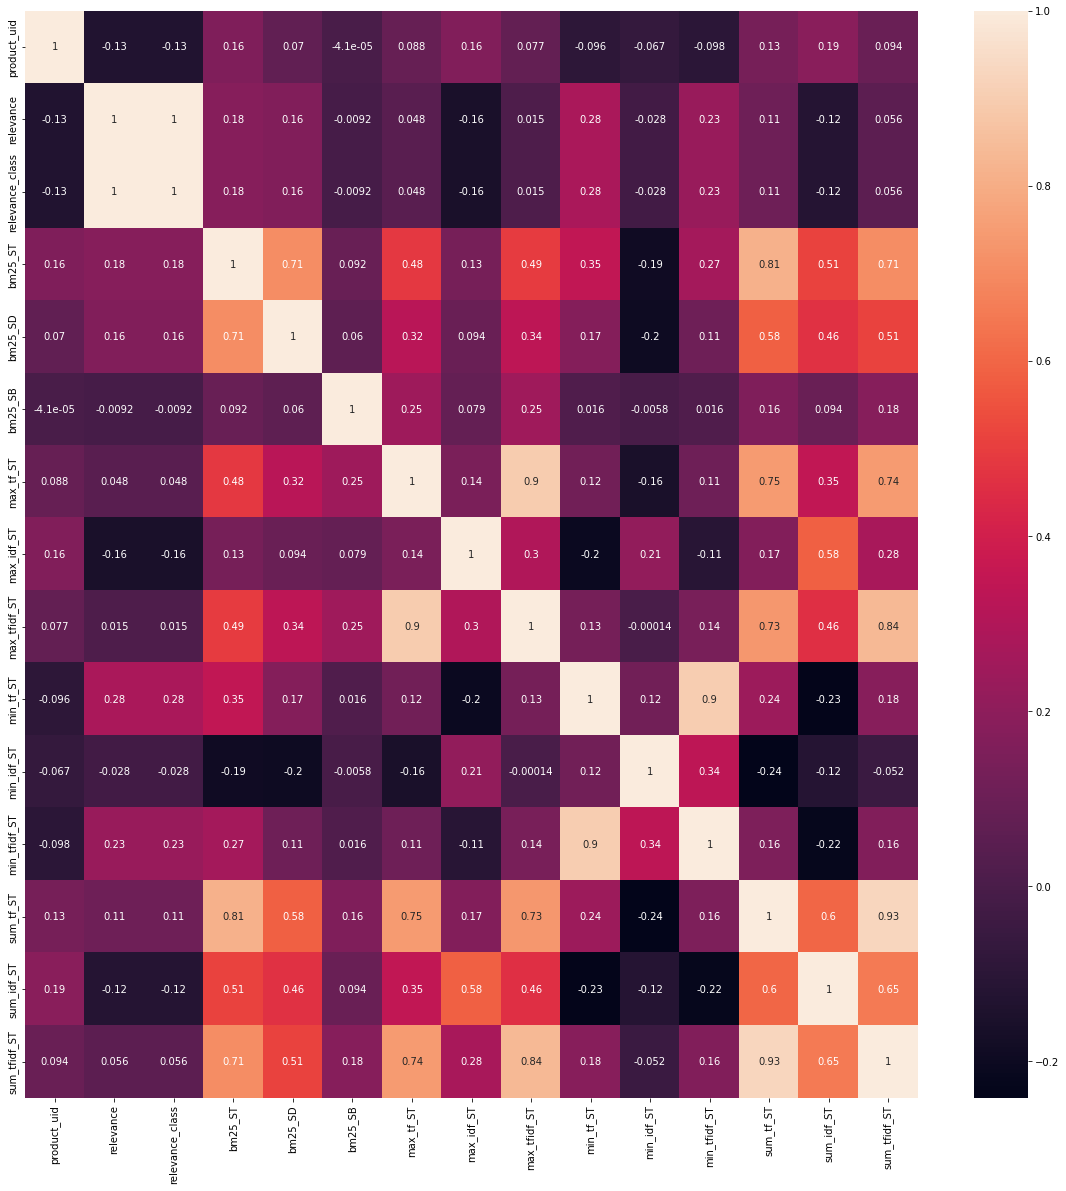

In [ ]:
#reference -- https://stackoverflow.com/questions/50259125/make-python-seaborn-heatmap-bigger
correlation_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_matrix, annot = True,ax=ax)
plt.show()
#interpretation of heatmpa-- https://stats.stackexchange.com/questions/392517/how-can-one-interpret-a-heat-map-plot

In [ ]:
df_train.corr()

In [ ]:
df_train.corr().abs().sort_values(by='relevance', axis=0, ascending=False)['relevance'].to_dict().keys()

In [ ]:
# df_train.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/Feature_train.csv')
# df_test.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/Feature_test.csv')

**Concatenation of all the features**

In [ ]:
FEATURES_LIST_IGNORE = ['product_uid','product_title','search_term','product_description','attribute_summary','brand','relevance','relevance_class']

In [ ]:
FEATURES_LIST_4_IGNORE=['max_cosine_sim_per_word_st_pt',
'max_cosine_sim_per_word_st_pd','w2v_n_similarity_st_pt','w2v_n_similarity_st_pd','w2v_centroid_rmse_st_pd','w2v_centroid_rmse_st_pt']

In [ ]:
FEATURES_LIST_5_IGNORE=['cosine_similarity_tfidf_search_title']

In [ ]:
FEATURES_LIST_1_IGNORE = ['product_uid','product_title','search_term','product_description','attribute_summary','brand','relevance_class']

In [ ]:
feat_list_1=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/basic_features.pkl')
feat_list_1=feat_list_1.drop(FEATURES_LIST_1_IGNORE,axis=1)
feat_list_2=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_1.pkl')
feat_list_2=feat_list_2.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_3=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_2.pkl')
feat_list_3=feat_list_3.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_5=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_4.pkl')
feat_list_5=feat_list_5.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_6=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_5.pkl')
feat_list_6=feat_list_6.drop(FEATURES_LIST_IGNORE,axis=1)

In [ ]:
feat_list_6.columns

Index(['bm25_ST', 'bm25_SD', 'bm25_SB', 'max_tf_ST', 'max_idf_ST',
       'max_tfidf_ST', 'min_tf_ST', 'min_idf_ST', 'min_tfidf_ST', 'sum_tf_ST',
       'sum_idf_ST', 'sum_tfidf_ST'],
      dtype='object')

In [ ]:
feat_list_1_wo_rel=feat_list_1.drop(['relevance'],axis=1)


In [ ]:
data_final = pd.concat([feat_list_1_wo_rel,feat_list_2, feat_list_3,feat_list_5,feat_list_6], axis=1)
print(feat_list_1_wo_rel.shape,feat_list_2.shape, feat_list_3.shape,feat_list_5.shape,feat_list_6.shape)

(59253, 8) (59253, 6) (59253, 13) (59253, 2) (59253, 12)


In [ ]:
data_final.columns

Index(['search_term_length', 'last_word_in_title', 'last_word_in_desc',
       'have_brand_or_not', 'have_attr_or_not', 'numbers_in_attr',
       'numbers_in_title', 'numbers_in_desc', 'title_common_word_count',
       'desc_common_word_count', 'attr_common_words_count',
       'title_common_word_count_bigram', 'desc_common_word_count_bigram',
       'attr_common_word_count_bigram', 'cosine_search_term_Title',
       'cosine_search_term_desc', 'search_term_contains_brand',
       'min_jcc_brand_with_search_term', 'min_edit_brand_with_search_term',
       'min_jcc_title_with_search_term', 'min_edit_title_with_search_term',
       'mean_jcc_product_title_with_search_term',
       'sum_jaccard_product_title_with_search_term',
       'sum_edit_product_title_with_search_term',
       'sum_jcc_prod_desc_with_search_term',
       'mean_jcc_product_desc_with_search_term',
       'mean_jcc_attr_with_search_term',
       'cosine_similarity_tfidf_search_title_des',
       'cosine_similarity_tfidf


The comple modeling stack is referred  from the below git repo.

---



**Reference**: https://github.com/kriz17/Home-Depot-Product-Search-Relevance/blob/master/Main/modelling1.ipynb

---

**Inference**

---


1. Train data is divided 80:20 and stored in Train_X, Train_Y, Test_X, Test_Y

2. For splitting into train and test (80-20) we have used train_test_split and then we always use random_state=122. This step is very important cause the Train_X needs to have the same indices in all the three modelling notebooks.

3. The test.csv data is not used for the training purpose

4. Train_X is further split into 50:50 --Train_X1, Train_Y1, Train_X2, Train_Y2

5. The data Train_X1, Train_Y1 is used for training each base models.

6. Train_X2, Train_Y2 is then used to train the meta classifier

7. For sampling we use, df.sample(). The sample datasets are succeeded with the characted S. So the first sample data is stored in X1_train_S1 with random state=101. The second in X2_train_S2 with random state 102 and so on the pattern is continued.




In [ ]:
Train_X= data_final
Train_Y = feat_list_1['relevance']
print(Train_X.shape, Train_Y.shape)

(59253, 41) (59253,)


In [ ]:
FEATURES_LIST_IGNORE = ['product_uid','product_title','search_term','product_description','attribute_summary','brand','relevance','relevance_class','id']
FEATURES_LIST_1_IGNORE_TEST = ['product_uid','product_title','search_term','product_description','attribute_summary','brand','relevance_class','id']

In [ ]:
feat_list_1_test=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/basic_features_test.pkl')
feat_list_1_test=feat_list_1_test.drop(FEATURES_LIST_1_IGNORE_TEST,axis=1)
feat_list_2_test=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_1_test.pkl')
feat_list_2_test=feat_list_2_test.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_3_test=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_2_test.pkl')
feat_list_3_test=feat_list_3_test.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_5_test=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_4_test.pkl')
feat_list_5_test=feat_list_5_test.drop(FEATURES_LIST_IGNORE,axis=1)
feat_list_6_test=pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/features_5_test.pkl')
feat_list_6_test=feat_list_6_test.drop(FEATURES_LIST_IGNORE,axis=1)

In [ ]:
feat_list_1_test_wo_rel=feat_list_1_test.drop(['relevance'],axis=1)

In [ ]:
data_final_test = pd.concat([feat_list_1_test_wo_rel,feat_list_2_test, feat_list_3_test,feat_list_5_test,feat_list_6_test], axis=1)
print(feat_list_1_test_wo_rel.shape,feat_list_2_test.shape, feat_list_3_test.shape,feat_list_5_test.shape,feat_list_6_test.shape)

(14814, 8) (14814, 6) (14814, 13) (14814, 2) (14814, 12)


In [ ]:
data_final_test.columns

Index(['search_term_length', 'last_word_in_title', 'last_word_in_desc',
       'have_brand_or_not', 'have_attr_or_not', 'numbers_in_attr',
       'numbers_in_title', 'numbers_in_desc', 'title_common_word_count',
       'desc_common_word_count', 'attr_common_words_count',
       'title_common_word_count_bigram', 'desc_common_word_count_bigram',
       'attr_common_word_count_bigram', 'cosine_search_term_Title',
       'cosine_search_term_desc', 'search_term_contains_brand',
       'min_jcc_brand_with_search_term', 'min_edit_brand_with_search_term',
       'min_jcc_title_with_search_term', 'min_edit_title_with_search_term',
       'mean_jcc_product_title_with_search_term',
       'sum_jaccard_product_title_with_search_term',
       'sum_edit_product_title_with_search_term',
       'sum_jcc_prod_desc_with_search_term',
       'mean_jcc_product_desc_with_search_term',
       'mean_jcc_attr_with_search_term',
       'cosine_similarity_tfidf_search_title_des',
       'cosine_similarity_tfidf

In [ ]:
Test_X= data_final_test
Test_Y = feat_list_1_test['relevance']
print(Test_X.shape, Test_Y.shape)

(14814, 41) (14814,)


In [ ]:
Train_X1, Train_X2, Train_Y1, Train_Y2 = train_test_split(Train_X, Train_Y, test_size=0.5, stratify=feat_list_1['relevance'], random_state = 122)

print(Train_X1.shape, Train_Y1.shape)
print(Train_X2.shape, Train_Y2.shape)

(29626, 41) (29626,)
(29627, 41) (29627,)


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint, loguniform
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

**Base Models**

In [ ]:
#Utility Functions
def display_results(results, thresh=0.1):
  ranks = results.cv_results_['rank_test_score']
  ind = np.argsort(ranks)
  sorted_train_scores = np.array(-results.cv_results_['mean_train_score'])[ind]
  sorted_test_scores = np.array(-results.cv_results_['mean_test_score'])[ind]
  sorted_params = np.array(results.cv_results_['params'])[ind]
  
  for i in range(len(ranks)):
    if (sorted_test_scores[i] - sorted_train_scores[i]) < thresh:
      print('train ->', sorted_train_scores[i])
      print('test ->', sorted_test_scores[i])
      print('params ->', sorted_params[i])
      print('*'*100)
    else: 
      continue

def plot_scores_single(results, param, log=False):
  '''
  Here you can use continuous distribution also for the single parameter
  '''
  X = [x[param] for x in results.cv_results_['params']]
  if log:
    X = [math.log10(a) for a in X]
  plt.plot(X, -results.cv_results_['mean_train_score'])
  plt.plot(X, -results.cv_results_['mean_test_score'])
  plt.title('rmse')
  plt.ylabel('rmse')
  plt.xlabel(param)
  plt.legend(['train', 'tets'], loc='lower left')
  plt.show()

# Model Stack

---
Main reference of the below model stack is https://github.com/kriz17/Home-Depot-Product-Search-Relevance/blob/master/Main/modelling1.ipynb



### XG Boost

In [ ]:
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [ ]:
X_train_S1 = Train_X1.sample(frac=0.85, random_state=101, axis=0)
y_train_S1 = Train_Y1.sample(frac=0.85, random_state=101, axis=0)
print(X_train_S1.shape, y_train_S1.shape)
DTrain = xgb.DMatrix(X_train_S1, label=y_train_S1)

(25182, 41) (25182,)


In [ ]:


params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}



In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,7)
    for min_child_weight in range(1,3)
]


In [ ]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        DTrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=3, min_child_weight=1
[0]	train-rmse:1.4131+0.000388486	test-rmse:1.41332+0.00210603
[10]	train-rmse:0.473372+0.000735261	test-rmse:0.478859+0.00252286
[20]	train-rmse:0.46498+0.000669669	test-rmse:0.474201+0.00278034
[30]	train-rmse:0.460972+0.000922156	test-rmse:0.472778+0.00270884
[40]	train-rmse:0.457895+0.000712817	test-rmse:0.472187+0.00282918
[50]	train-rmse:0.455+0.000625537	test-rmse:0.471728+0.00301199
[60]	train-rmse:0.452326+0.000758402	test-rmse:0.471468+0.00290068
[70]	train-rmse:0.449888+0.000752455	test-rmse:0.471451+0.00281041
[80]	train-rmse:0.447243+0.000717052	test-rmse:0.471147+0.00270369
[90]	train-rmse:0.444839+0.000677296	test-rmse:0.471149+0.00260552
[100]	train-rmse:0.44268+0.000771898	test-rmse:0.471161+0.00254964
	rmse 0.47103140000000004 for 92 rounds
CV with max_depth=3, min_child_weight=2
[0]	train-rmse:1.4131+0.000388486	test-rmse:1.41332+0.00210603
[10]	train-rmse:0.473372+0.000735261	test-rmse:0.478859+0.00252286
[20]	train-rmse:0.464

In [ ]:
params['max_depth'] = 6
params['min_child_weight'] = 1

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(9,11)]
    for colsample in [i/10. for i in range(9,11)]
]

In [ ]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        DTrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
[0]	train-rmse:1.41114+0.000456316	test-rmse:1.41218+0.00208072
[10]	train-rmse:0.441555+0.000271838	test-rmse:0.473825+0.00220327
[20]	train-rmse:0.421462+0.00101244	test-rmse:0.472374+0.00244952
[30]	train-rmse:0.408768+0.00187899	test-rmse:0.472964+0.00259331
	rmse 0.47218340000000003 for 22 rounds
CV with subsample=1.0, colsample=0.9
[0]	train-rmse:1.41115+0.000457978	test-rmse:1.41225+0.00203952
[10]	train-rmse:0.442112+0.00084498	test-rmse:0.473638+0.00238223
[20]	train-rmse:0.423043+0.00135443	test-rmse:0.471894+0.00226762
[30]	train-rmse:0.410881+0.00203746	test-rmse:0.471757+0.00245554
	rmse 0.47158999999999995 for 27 rounds
CV with subsample=0.9, colsample=1.0
[0]	train-rmse:1.41097+0.000401815	test-rmse:1.41215+0.00205992
[10]	train-rmse:0.442038+0.00100575	test-rmse:0.473455+0.00238121
[20]	train-rmse:0.422169+0.00152824	test-rmse:0.471229+0.00282763
	rmse 0.47121880000000005 for 19 rounds
CV with subsample=0.9, colsample=0.9
[0]	train-r

In [ ]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.9

In [ ]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
                params,
                DTrain,
                num_boost_round=999,
                seed=42,
                nfold=5,
                metrics=['rmse'],
                early_stopping_rounds=10,
                verbose_eval=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
[0]	train-rmse:1.41115+0.000457978	test-rmse:1.41225+0.00203952
[10]	train-rmse:0.442112+0.00084498	test-rmse:0.473638+0.00238223
[20]	train-rmse:0.423043+0.00135443	test-rmse:0.471894+0.00226762
[30]	train-rmse:0.410881+0.00203746	test-rmse:0.471757+0.00245554
	rmse 0.47158999999999995 for 27 rounds

CV with eta=0.2
[0]	train-rmse:1.59088+0.00055923	test-rmse:1.59151+0.00237526
[10]	train-rmse:0.479824+0.000525891	test-rmse:0.500825+0.00195415
[20]	train-rmse:0.43333+0.00069648	test-rmse:0.471043+0.0021544
[30]	train-rmse:0.421935+0.000831358	test-rmse:0.469788+0.00243246
[40]	train-rmse:0.412827+0.00127433	test-rmse:0.470003+0.00269178
	rmse 0.4697732 for 31 rounds

CV with eta=0.1
[0]	train-rmse:1.77262+0.000661672	test-rmse:1.77289+0.00271355
[10]	train-rmse:0.755802+0.000275285	test-rmse:0.76328+0.000980187
[20]	train-rmse:0.497077+0.000300196	test-rmse:0.516338+0.0012052
[30]	train-rmse:0.446507+0.000415492	test-rmse:0.475883+0.00173704
[40]	train-rmse:0.432899+0.

In [ ]:
params['eta'] = 0.05
print('Final parameters look like')
params

Final parameters look like


{'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86406+0.000716125	test-rmse:1.86419+0.0028781
[10]	train-rmse:1.17853+0.000335533	test-rmse:1.18113+0.00178643
[20]	train-rmse:0.796818+0.000303972	test-rmse:0.803858+0.000959021
[30]	train-rmse:0.600016+0.000374363	test-rmse:0.612709+0.000561976
[40]	train-rmse:0.507821+0.000376938	test-rmse:0.526554+0.00107125
[50]	train-rmse:0.46695+0.000428799	test-rmse:0.4912+0.00164823
[60]	train-rmse:0.448604+0.000457974	test-rmse:0.47743+0.00205681
[70]	train-rmse:0.43895+0.000442724	test-rmse:0.471791+0.0021391
[80]	train-rmse:0.433512+0.000313643	test-rmse:0.469617+0.00217485
[90]	train-rmse:0.429597+0.00041978	test-rmse:0.46864+0.00228784
[100]	train-rmse:0.426688+0.000737509	test-rmse:0.468118+0.00213159
[110]	train-rmse:0.424082+0.000915531	test-rmse:0.467846+0.00220217
[120]	train-rmse:0.421665+0.00111945	test-rmse:0.467589+0.00219615
[130]	train-rmse:0.419453+0.00125862	test-rmse:0.467394+0.00210098
[140]	train-rmse:0.417307+0.00148048	test-rmse:0.467215+0.00200892
[150]

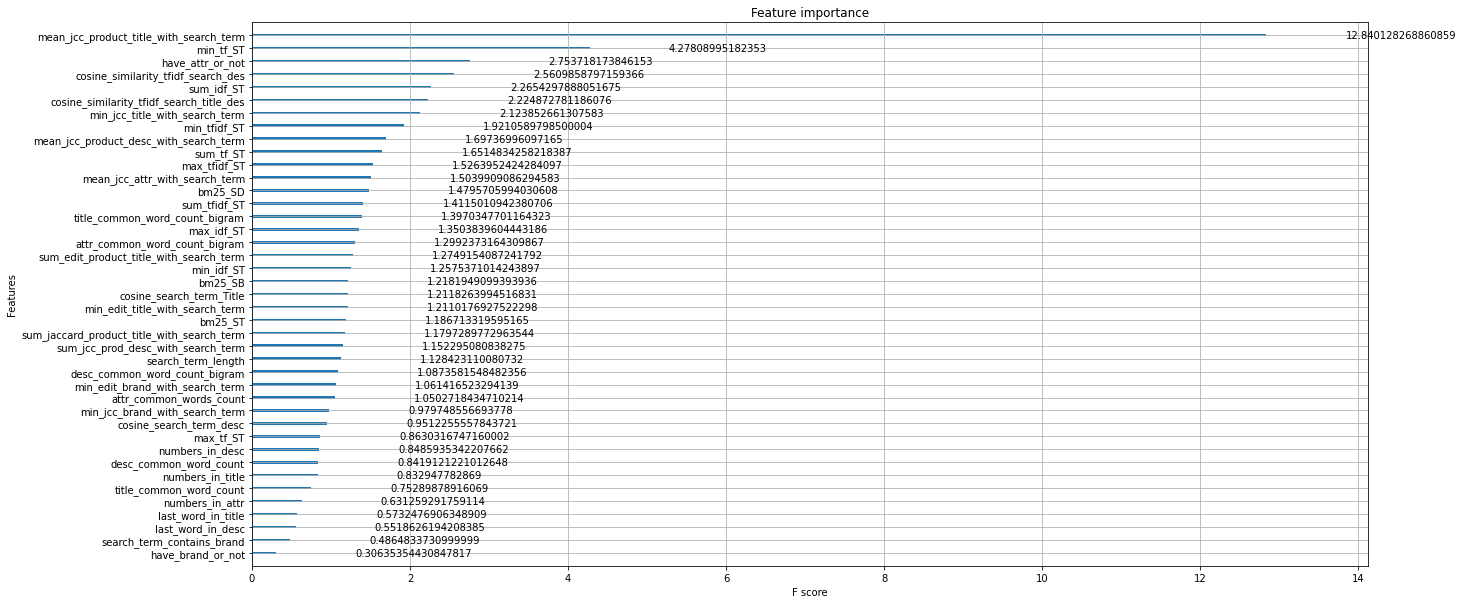

In [ ]:
model = xgb.train(
    params,
    DTrain,
    num_boost_round=350,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

In [ ]:
best_params = {'colsample_bytree': 0.9,
 'n_estimators': 999,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

# model = XGBRegressor(**params_sklearn)
# scores = xgb_model_fit(X, y, model)

xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train_S1, y_train_S1)
pickle.dump(xgb_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_xgb.pkl', "wb"))

In [ ]:
# best_params = {'colsample_bytree': 0.8,
#  'learning_rate': 0.05,
#  'max_depth': 7,
#  'min_child_weight': 250,
#  'objective': 'reg:squarederror',
#  'subsample': 0.8, 
#  'n_estimators' : 350}

# xgb_model = XGBRegressor(**best_params)
# xgb_model.fit(X_train_S1, y_train_S1)
# pickle.dump(xgb_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_xgb.pkl', "wb"))

## Random Forest Regressor

In [ ]:
X_train_S2 = Train_X1.sample(frac=0.85, random_state=102, axis=0)
y_train_S2 = Train_Y1.sample(frac=0.85, random_state=102, axis=0)

print(X_train_S2.shape, y_train_S2.shape)

(25182, 41) (25182,)


In [ ]:
%%time
random_grid = {
               #'bootstrap': [True],
               'max_depth': [12, 15, 17, 20], 
               'max_features': [0.5, 0.7, 0.8, 0.9], 
               'min_samples_leaf': [20, 50, 100],
               #'n_estimators': 50
               }

model = RandomForestRegressor(max_features=0.2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, max_depth=12)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S2, y_train_S2)
# summarize
print('best rmse:', 'test', -results.best_score_, 'corresponding train', -results.cv_results_['mean_train_score'][results.best_index_])
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


best rmse: test 0.46781914226183985 corresponding train 0.4101273333972026
Config: {'min_samples_leaf': 20, 'max_features': 0.5, 'max_depth': 20}


In [ ]:
%%time
best_params = {'bootstrap':True, 
               'min_samples_leaf': 20, 
               'max_features': 0.8, 
               'max_depth': 17, 
               'n_estimators': 100}

rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train_S2, y_train_S2)

pickle.dump(rf_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_rf.pkl', "wb"))

CPU times: user 29.1 s, sys: 65.2 ms, total: 29.1 s
Wall time: 29 s


In [ ]:
# %%time
y_pred = rf_model.predict(X_train_S2)
mean_squared_error(y_train_S2, y_pred, squared=False)

0.40529719672264586

## Ridge Regression

In [ ]:
%%time
X_train_S3 = Train_X1.sample(frac=0.85, random_state=103, axis=0)
y_train_S3 = Train_Y1.sample(frac=0.85, random_state=103, axis=0)

print(X_train_S3.shape, y_train_S3.shape)
print('number of unique datapoints', len(set(X_train_S3.index)))

(25182, 41) (25182,)
number of unique datapoints 25182
CPU times: user 21.5 ms, sys: 2 ms, total: 23.5 ms
Wall time: 21.8 ms


In [ ]:
%%time
scaler = StandardScaler()
X_std3 = scaler.fit_transform(X_train_S3)

CPU times: user 193 ms, sys: 25 ms, total: 218 ms
Wall time: 216 ms


best rmse: test 0.4813237686998512 train 0.4799175652544969
Config: {'alpha': 18.356566544355076}


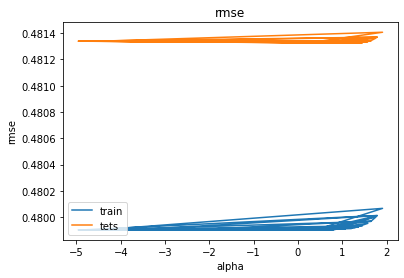

CPU times: user 860 ms, sys: 184 ms, total: 1.04 s
Wall time: 4.73 s


In [ ]:
%%time
random_grid = {
               'alpha':loguniform(1e-5, 1e2)
               }

model = Ridge()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std3, y_train_S3)
# summarize
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][results.best_index_])
print('Config: %s' % results.best_params_)

plot_scores_single(results, 'alpha', log=True)

In [ ]:
%%time
best_params = {'alpha': 6.715}

scaler_ridge = StandardScaler()
X_std3 = scaler_ridge.fit_transform(X_train_S3)

ridge_model = Ridge(**best_params)
ridge_model.fit(X_std3, y_train_S3)

pickle.dump(scaler_ridge, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_ridge.pkl', "wb"))
pickle.dump(ridge_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_ridge.pkl', "wb"))

CPU times: user 191 ms, sys: 48.9 ms, total: 240 ms
Wall time: 233 ms


## Lasso Regression

In [ ]:
%%time
X_train_S4 = Train_X1.sample(frac=0.85, random_state=104, axis=0)
y_train_S4 = Train_Y1.sample(frac=0.85, random_state=104, axis=0)

print(X_train_S4.shape, y_train_S4.shape)
print('number of unique datapoints', len(set(X_train_S4.index)))

(25182, 41) (25182,)
number of unique datapoints 25182
CPU times: user 28.1 ms, sys: 36.9 ms, total: 65.1 ms
Wall time: 36.6 ms


In [ ]:
%%time
scaler = StandardScaler()
X_std4 = scaler.fit_transform(X_train_S4)

CPU times: user 202 ms, sys: 66.9 ms, total: 269 ms
Wall time: 242 ms


best rmse: test 0.48007201890471024 train 0.4788110588945611
Config: {'alpha': 0.000234238498471129}


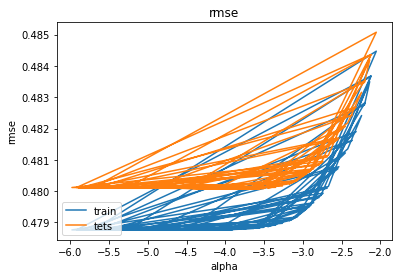

CPU times: user 4.08 s, sys: 584 ms, total: 4.67 s
Wall time: 2min 7s


In [ ]:
%%time
random_grid = {
               'alpha':loguniform(1e-6, 1e-2)
               }

model = Lasso()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std4, y_train_S4)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

plot_scores_single(results, 'alpha', log=True)

In [ ]:
%%time
best_params = {'alpha':6.6723e-05}

scaler_lasso = StandardScaler()
X_std4 = scaler_lasso.fit_transform(X_train_S4)

lasso_model = Lasso(**best_params)
lasso_model.fit(X_std4, y_train_S4)

pickle.dump(scaler_lasso, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_lasso.pkl', "wb"))
pickle.dump(lasso_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_lasso.pkl', "wb"))

CPU times: user 1.29 s, sys: 221 ms, total: 1.51 s
Wall time: 888 ms


## Elastic Net Regression

In [ ]:
X_train_S5 = Train_X1.sample(frac=0.85, random_state=105, axis=0)
y_train_S5 = Train_Y1.sample(frac=0.85, random_state=105, axis=0)

print(X_train_S5.shape, y_train_S5.shape)
print('number of unique datapoints', len(set(X_train_S5.index)))

(25182, 41) (25182,)
number of unique datapoints 25182


In [ ]:
scaler = StandardScaler()
X_std5 = scaler.fit_transform(X_train_S5)

In [ ]:
%%time
random_grid = {
               'alpha': loguniform(1e-5, 1e2),
               'l1_ratio': uniform(0,1)
               }

model = ElasticNet()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std5, y_train_S5)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

best rmse: test 0.48130214500183666 train 0.4803274416568631
Config: {'alpha': 0.00024987135684669453, 'l1_ratio': 0.5142344384136116}
CPU times: user 3.37 s, sys: 407 ms, total: 3.77 s
Wall time: 53.1 s


In [ ]:
%%time
best_params = {'alpha': 0.0004, 'l1_ratio': 0.077}

scaler_en = StandardScaler()
X_std5 = scaler_en.fit_transform(X_train_S5)

en_model = ElasticNet(**best_params)
en_model.fit(X_std5, y_train_S5)

pickle.dump(scaler_en, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_en.pkl', "wb"))
pickle.dump(en_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_en.pkl', "wb"))

CPU times: user 1.35 s, sys: 312 ms, total: 1.66 s
Wall time: 971 ms


## Decision Tree Regressor

In [ ]:
X_train_S6 = Train_X1.sample(frac=0.85, random_state=107, axis=0)
y_train_S6 = Train_Y1.sample(frac=0.85, random_state=107, axis=0)

print(X_train_S6.shape, y_train_S6.shape)
print('number of unique datapoints', len(set(X_train_S6.index)))

(25182, 41) (25182,)
number of unique datapoints 25182


In [ ]:
%%time
random_grid = {
               #'criterion' : ['mse', 'mae'],
               'max_depth' : randint(2, 15),
               'max_features' : uniform(0, 1),
               'min_samples_leaf' : [2, 10, 20, 50, 100, 1000]
               }

model = DecisionTreeRegressor(criterion='mse', min_samples_leaf=100)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 200, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S6, y_train_S6)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
best rmse: test 0.4826301581575177 train 0.4732007903335762
Config: {'max_depth': 6, 'max_features': 0.5722924691708383, 'min_samples_leaf': 50}
CPU times: user 6.18 s, sys: 610 ms, total: 6.79 s
Wall time: 1min 57s


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [ ]:
%%time
best_params = {'max_depth': 6, 'max_features': 0.5723, 'min_samples_leaf': 50}

dt_model = DecisionTreeRegressor(**best_params)
dt_model.fit(X_train_S6, y_train_S6)

pickle.dump(dt_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_dt.pkl', "wb"))

CPU times: user 242 ms, sys: 9.99 ms, total: 252 ms
Wall time: 256 ms


## Meta Classifier Dataset

In [ ]:
#Loading the standard scalers
M1_scaler_ridge = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_ridge.pkl', 'rb'))
M1_scaler_lasso = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_lasso.pkl', 'rb'))
M1_scaler_en = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_scaler_en.pkl', 'rb'))


#Loading the models 
M1_xgb = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_xgb.pkl', 'rb'))
M1_rf = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_rf.pkl', 'rb'))
M1_ridge = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_ridge.pkl', 'rb'))
M1_lasso = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_lasso.pkl', 'rb'))
M1_en = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_en.pkl', 'rb'))
M1_dt = pickle.load(open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/M1_dt.pkl', 'rb'))

In [ ]:
pred_xgb = M1_xgb.predict(Train_X2) 
pred_rf = M1_rf.predict(Train_X2) 
pred_ridge = M1_ridge.predict(M1_scaler_ridge.transform(Train_X2)) 
pred_lasso = M1_lasso.predict(M1_scaler_lasso.transform(Train_X2)) 
pred_en = M1_en.predict(M1_scaler_en.transform(Train_X2)) 
pred_dt = M1_dt.predict(Train_X2)

In [ ]:
arr = np.hstack((pred_xgb.reshape(-1,1),
                 pred_rf.reshape(-1,1), 
                 pred_dt.reshape(-1,1),
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1)))

M1_df_train = pd.DataFrame(arr, columns=['M1_xgb', 'M1_rf', 'M1_dt','M1_ridge', 'M1_lasso', 'M1_en'], index=Train_X2.index)
M1_df_train.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/Train_X2_M1.pkl')

**Test data**

In [ ]:
Test_X

,search_term_length,last_word_in_title,last_word_in_desc,have_brand_or_not,have_attr_or_not,numbers_in_attr,numbers_in_title,numbers_in_desc,title_common_word_count,desc_common_word_count,attr_common_words_count,title_common_word_count_bigram,desc_common_word_count_bigram,attr_common_word_count_bigram,cosine_search_term_Title,cosine_search_term_desc,search_term_contains_brand,min_jcc_brand_with_search_term,min_edit_brand_with_search_term,min_jcc_title_with_search_term,min_edit_title_with_search_term,mean_jcc_product_title_with_search_term,sum_jaccard_product_title_with_search_term,sum_edit_product_title_with_search_term,sum_jcc_prod_desc_with_search_term,mean_jcc_product_desc_with_search_term,mean_jcc_attr_with_search_term,cosine_similarity_tfidf_search_title_des,cosine_similarity_tfidf_search_des,bm25_ST,bm25_SD,bm25_SB,max_tf_ST,max_idf_ST,max_tfidf_ST,min_tf_ST,min_idf_ST,min_tfidf_ST,sum_tf_ST,sum_idf_ST,sum_tfidf_ST
0,22,False,False,True,True,0,0,0,40,468,248,27,603,255,0.316228,0.092450,0,1.000000,3,0.00,0,0.333333,0.833333,42,0.983193,0.225000,0.336111,0.134760,0.085909,13.862559,10.156426,0.0,1,10.903145,6.131704,0,2.708426,0.000000,2,27.695175,8.840129
1,22,True,True,True,True,0,0,0,25,345,250,16,332,252,0.400000,0.107676,0,0.714286,4,0.00,0,0.445714,0.750000,12,0.972222,0.116667,0.342857,0.488012,0.370269,21.005628,25.062483,0.0,1,10.903145,6.640455,0,2.026515,0.000000,2,36.811883,12.979079
2,38,False,False,True,True,0,0,0,40,500,660,28,496,808,0.316228,0.089893,0,0.666667,5,0.00,0,0.280952,0.818182,28,0.980392,0.188889,0.174603,0.368084,0.244689,13.299199,9.750276,0.0,1,7.074831,5.666775,0,3.154046,0.000000,2,25.782958,8.820822
3,20,False,False,True,True,0,0,0,28,260,252,18,264,243,0.377964,0.186052,0,1.000000,12,0.00,0,0.283333,0.777778,29,0.954545,0.125000,0.083333,0.417122,0.367432,13.433871,17.405084,0.0,1,10.903145,6.821740,0,3.471509,0.000000,2,32.099539,10.293250
4,16,False,True,True,True,0,0,0,21,228,225,12,204,206,0.218218,0.132453,0,0.600000,2,0.00,0,0.321429,0.888889,22,0.974026,0.166667,0.357143,0.239824,0.215175,13.399479,10.977546,0.0,1,5.818645,3.950881,0,3.628023,0.000000,2,13.397550,7.578904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14809,19,True,True,True,True,0,0,0,42,303,339,28,252,290,0.480384,0.172345,0,0.285714,1,0.00,0,0.000000,0.769231,60,0.970297,0.000000,0.055556,0.524199,0.426138,22.762294,22.821506,0.0,2,7.744262,8.151808,1,3.983061,3.983061,4,15.803227,19.879131
14810,13,False,False,False,False,0,0,0,16,118,2,7,75,0,0.000000,0.092057,0,0.800000,6,0.25,4,0.402778,1.000000,47,0.983333,0.222222,0.681818,0.289931,0.315063,8.672214,22.826737,0.0,1,8.535849,3.793018,0,3.793018,0.000000,1,12.328867,3.793018
14811,22,False,False,True,True,0,0,0,39,129,132,24,104,98,0.160128,0.088045,0,0.727273,5,0.00,0,0.208333,0.933333,47,0.977778,0.226852,0.407407,0.164366,0.143143,6.031414,6.743205,0.0,1,5.725201,5.043530,0,3.965056,0.000000,1,14.733786,5.043530
14812,26,True,True,True,True,3,3,0,72,390,642,60,395,705,0.615457,0.050637,0,0.700000,8,0.00,0,0.125000,0.583333,44,0.985714,0.566667,0.103175,0.363663,0.256745,19.350595,9.190593,0.0,2,10.903145,21.806289,0,3.281952,0.000000,6,45.395685,50.522554


In [ ]:
pred_xgb = M1_xgb.predict(Test_X) 
pred_rf = M1_rf.predict(Test_X) 
pred_ridge = M1_ridge.predict(M1_scaler_ridge.transform(Test_X)) 
pred_lasso = M1_lasso.predict(M1_scaler_lasso.transform(Test_X)) 
pred_en = M1_en.predict(M1_scaler_en.transform(Test_X)) 
pred_dt = M1_dt.predict(Test_X)

In [ ]:
arr = np.hstack((pred_xgb.reshape(-1,1),
                 pred_rf.reshape(-1,1), 
                 pred_dt.reshape(-1,1),
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1)))

M1_df_test= pd.DataFrame(arr, columns=['M1_xgb', 'M1_rf', 'M1_dt','M1_ridge', 'M1_lasso', 'M1_en'], index=Test_X.index)
M1_df_test.to_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/Test_X_M1.pkl')

In [ ]:
M1_df_test

,M1_xgb,M1_rf,M1_dt,M1_ridge,M1_lasso,M1_en
0,1.836815,1.957009,1.950119,2.021607,2.022536,2.007471
1,2.617466,2.231048,2.118027,2.208881,2.234921,2.215556
2,2.251736,2.255471,2.217643,2.383125,2.389986,2.389463
3,2.105150,2.219128,2.328103,2.281977,2.281767,2.282010
4,2.016355,2.211326,2.433738,2.298994,2.305960,2.299988
...,...,...,...,...,...,...
14809,2.797727,2.781784,2.757358,2.690945,2.705033,2.695549
14810,2.851052,2.510791,2.433738,2.475126,2.491881,2.465897
14811,2.356024,2.278951,2.433738,2.260840,2.260098,2.256206
14812,2.416698,2.402564,2.217643,2.312981,2.344547,2.333522


#### Meta Classifier model

In [ ]:
train_x = pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/Train_X2_M1.pkl')
train_y = Train_Y2
print(train_x.shape, train_y.shape)

(29627, 6) (29627,)


In [ ]:
test_x = pd.read_pickle('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/Test_X_M1.pkl')
test_y = Test_Y
print(test_x.shape, test_y.shape)

(14814, 6) (14814,)


In [ ]:
scaler_final = StandardScaler()
train_x_std = scaler_final.fit_transform(train_x)

best rmse: cv 0.4624542812587327 train 0.4624036498569962
best param {'alpha': 70.31782636609873}


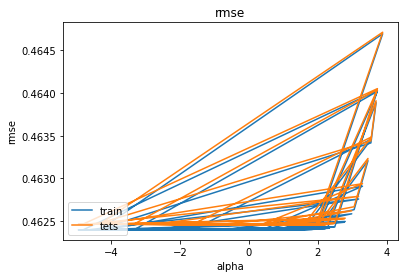

In [ ]:
random_grid = {
               'alpha': loguniform(1e-5, 1e4)
               }

model = Ridge()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 5, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(train_x_std, train_y)
# summarize
print('best rmse:', 'cv', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][results.best_index_])
print('best param', results.best_params_)

plot_scores_single(results, 'alpha', log=True)

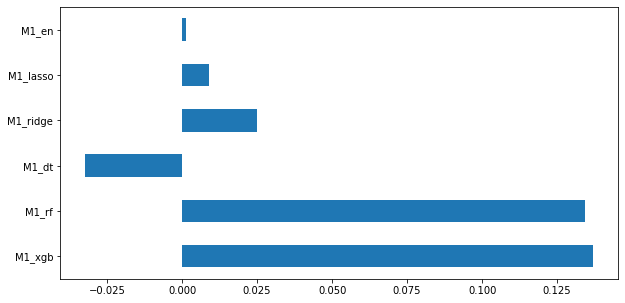

In [ ]:
best_params = {'alpha': 116.5}
ridge_model = Ridge(**best_params)
ridge_model.fit(train_x_std, train_y)

importance = ridge_model.coef_
plt.figure(figsize=(10, 5))
pd.Series(importance, index=train_x.columns).plot(kind='barh')
plt.show()

In [ ]:
pickle.dump(scaler_final, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/meta_scaler.pkl', "wb"))
pickle.dump(ridge_model, open('/gdrive/MyDrive/ColabNotebooks/thesis/corrected/model/meta_ridge.pkl', "wb"))

In [ ]:
test_x

,M1_xgb,M1_rf,M1_dt,M1_ridge,M1_lasso,M1_en
0,1.836815,1.957009,1.950119,2.021607,2.022536,2.007471
1,2.617466,2.231048,2.118027,2.208881,2.234921,2.215556
2,2.251736,2.255471,2.217643,2.383125,2.389986,2.389463
3,2.105150,2.219128,2.328103,2.281977,2.281767,2.282010
4,2.016355,2.211326,2.433738,2.298994,2.305960,2.299988
...,...,...,...,...,...,...
14809,2.797727,2.781784,2.757358,2.690945,2.705033,2.695549
14810,2.851052,2.510791,2.433738,2.475126,2.491881,2.465897
14811,2.356024,2.278951,2.433738,2.260840,2.260098,2.256206
14812,2.416698,2.402564,2.217643,2.312981,2.344547,2.333522


In [ ]:
test_x_std = scaler_final.transform(test_x)

In [ ]:
test_y_pred = ridge_model.predict(test_x_std)

In [ ]:
test_y_pred.shape

(14814,)

In [ ]:
rmse = mean_squared_error(test_y, test_y_pred, squared=False)
print('Final Error on test Data is:', rmse)

Final Error on test Data is: 0.4630094015714122
